In [124]:
import pandas as pd
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier as XGBC

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

import os.path
import pickle

import datetime as dt

already_trained = os.path.exists('./DIX-GEX-ml.model')

df_dix = pd.read_csv('https://squeezemetrics.com/monitor/static/DIX.csv',
                      names=['Date','SP500','DIX','GEX'], index_col='Date', parse_dates=['Date'], header=0)

df_vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv',
                     skiprows=1, index_col='Date', parse_dates=['Date']).rename(columns={'VIX Close' : 'VIX'})

start = dt.datetime(2011,1,1)
end = dt.datetime.today()

df_spy = web.DataReader('SPY','yahoo', start, end).rename(columns={'Volume' : 'SPY Volume'})

In [125]:
df_data = df_dix.join(df_vix['VIX'], how='left')
df_data = df_data.join(df_spy['SPY Volume'], how='left')

df_data['SP500 EWM20'] = df_data['SP500'].ewm(span=20, adjust=False).mean()

for col in ['DIX', 'GEX']:
    df_data[col + ' Diff.'] = df_data[col].diff()
    
df_data['SP500 EWM20 Diff.'] = df_data['SP500'] - df_data['SP500 EWM20']

df_data = df_data.dropna()

df_data

,SP500,DIX,GEX,VIX,SPY Volume,SP500 EWM20,DIX Diff.,GEX Diff.,SP500 EWM20 Diff.
Date,,,,,,,,,
2011-05-03,1356.619995,0.383411,1.859731e+09,16.70,138375000.0,1360.781878,0.004569,-3.758192e+07,-4.161883
2011-05-04,1347.319946,0.392122,1.717764e+09,17.08,182678500.0,1359.499789,0.008711,-1.419668e+08,-12.179843
2011-05-05,1335.099976,0.405457,1.361864e+09,18.20,226900000.0,1357.175998,0.013335,-3.558996e+08,-22.076022
2011-05-06,1340.199951,0.418649,1.490329e+09,18.40,222787200.0,1355.559231,0.013192,1.284643e+08,-15.359280
2011-05-09,1346.290039,0.410321,1.677059e+09,17.16,114104500.0,1354.676451,-0.008328,1.867301e+08,-8.386412
...,...,...,...,...,...,...,...,...,...
2020-04-03,2488.650000,0.506475,-4.630797e+08,46.80,135561200.0,2600.337094,0.021254,4.431874e+07,-111.687094
2020-04-06,2663.680000,0.446698,1.555165e+09,45.24,188061200.0,2606.369751,-0.059777,2.018244e+09,57.310249
2020-04-07,2659.410000,0.482110,1.533925e+09,46.70,201427200.0,2611.421204,0.035412,-2.123946e+07,47.988796


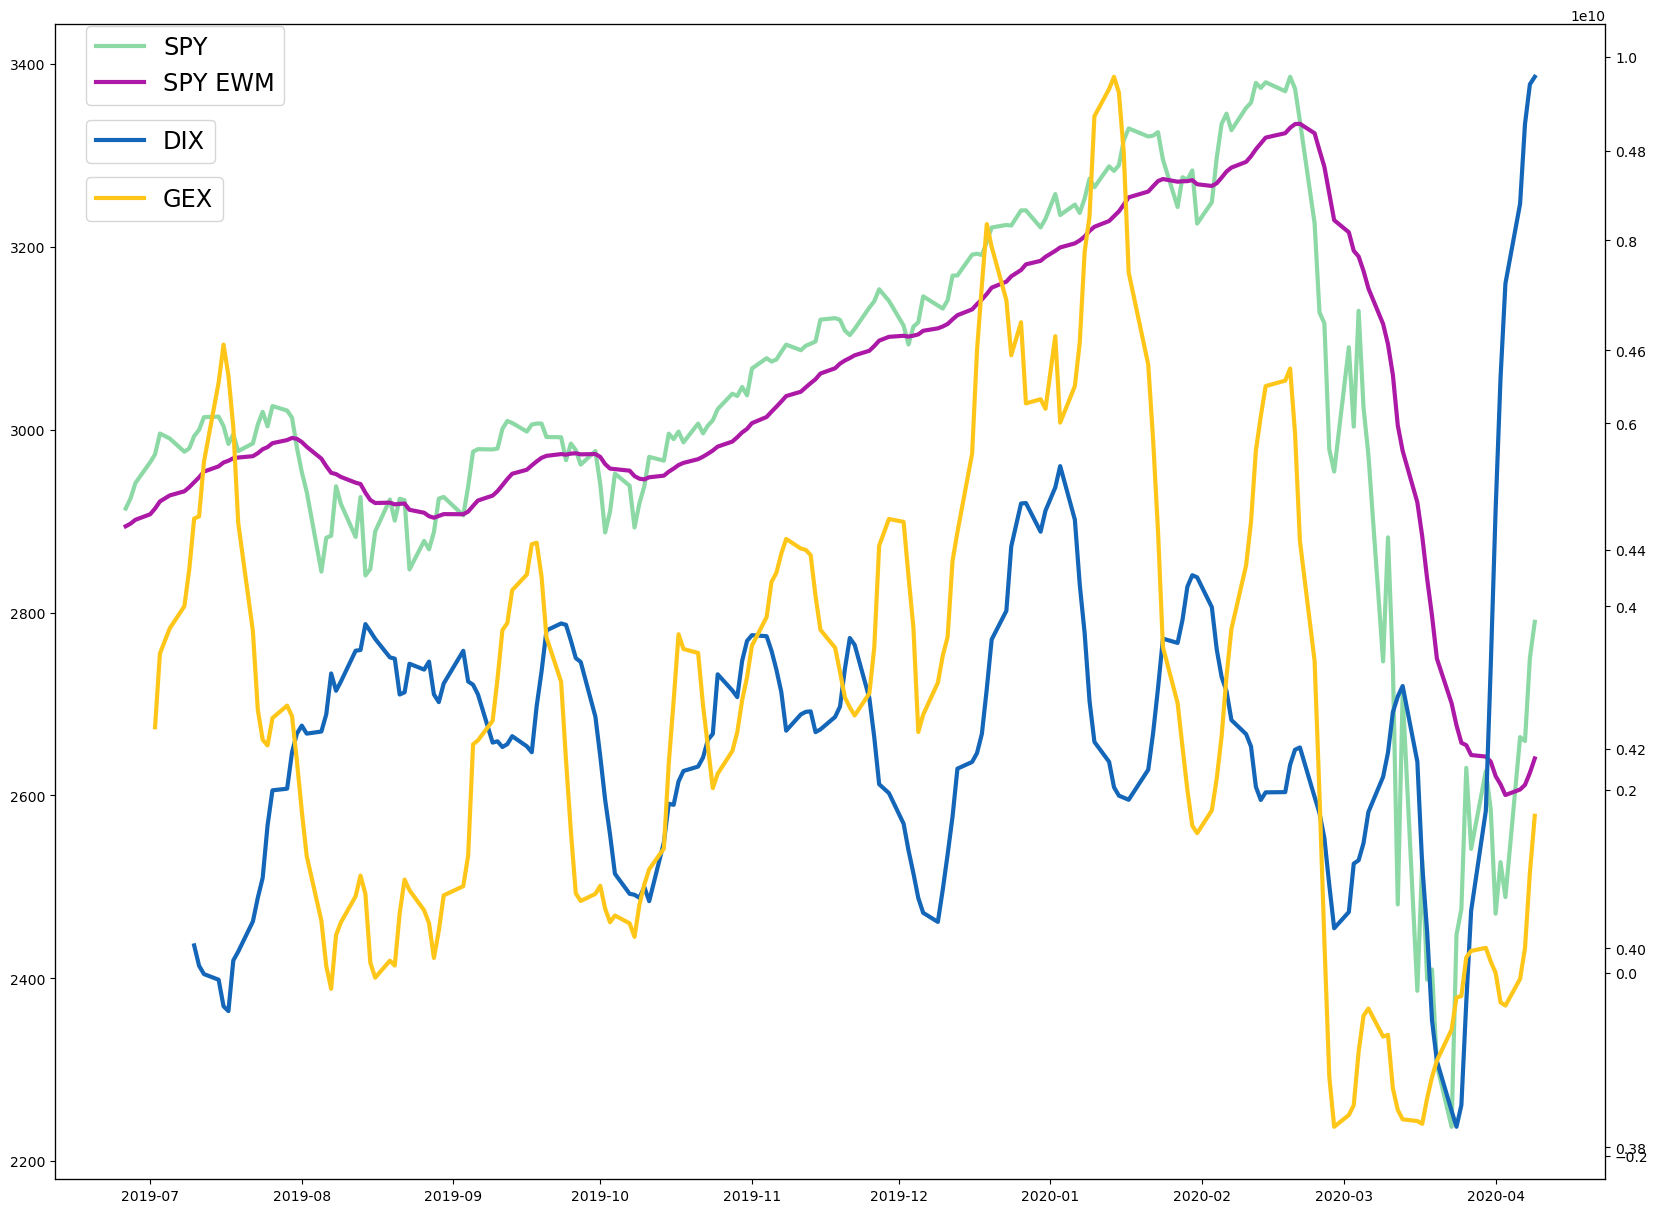

In [139]:
df_recent = df_data.tail(200)

fig, ax1 = plt.subplots(figsize=(20,15))

ax1.plot(df_recent['SP500'].rolling(window=1).mean(), label='SPY', color='#8cd9a6', linewidth=3)
ax1.plot(df_recent['SP500 EWM20'].rolling(window=1).mean(), label='SPY EWM', color='#ac19a6', linewidth=3)
ax2 = ax1.twinx()
ax2.plot(df_recent['DIX'].rolling(window=10).mean(), label='DIX', color='#1466b8', linewidth=3)
ax3= ax1.twinx()
ax3.plot(df_recent['GEX'].rolling(window=5).mean(), label='GEX', color='#ffc61a', linewidth=3)

ax1.legend(fontsize='xx-large', loc=(0.02,0.93))
ax2.legend(fontsize='xx-large', loc=(0.02,0.88))
ax3.legend(fontsize='xx-large', loc=(0.02,0.83))

plt.show()

In [127]:
#Sell Signal: DIX < 0.4 + 1-day DIX decline + 1-day GEX decline + GEX positive and SPX > EMA(20)
#https://nextsignals.com/wp-content/uploads/2019/09/Analysis_DIX-GEX-Sell_Signals-3.pdf

#Signal A: DIX < 0.4
#Signal B: DIX Diff. < 0
#Signal C: GEX Diff. < 0
#Signal D: GEX > 0
#Signal E: SP500 > SP500 EWM20

df_data['Signal A'] = df_data['DIX'].map(lambda x : 1 if x < 0.4 else 0)
df_data['Signal B'] = df_data['DIX Diff.'].map(lambda x : 1 if x < 0 else 0)
df_data['Signal C'] = df_data['GEX Diff.'].map(lambda x : 1 if x < 0 else 0)
df_data['Signal D'] = df_data['GEX'].map(lambda x : 1 if x > 0 else 0)
df_data['Signal E'] = df_data['SP500 EWM20 Diff.'].map(lambda x : 1 if x > 0 else 0)

df_data['Signals'] = df_data.loc[ : , 'Signal A':'Signal E'].sum(axis=1)

In [128]:
#labelling buy/sell/hold signal


#establish thresholds for buy or sell (-d%, +u%)
#in next k trading days, which threshold is met first?

def label_data(df, u=2.3, d=1.6, U=3.9, D=3.5, k=20):
    n = len(df)
    i = 0
    
    prices = df['SP500']
    labels = []
    
    for i in range(n):
        base_price = prices.iloc[i]
        label = 2 # hold
        
        for j in range(i+1, min(i+k+1, n)):
            new_price = prices.iloc[j]
            pct_change = 100 * (new_price-base_price)/base_price
            if pct_change >= U:
                label = 4 # strong buy
                break
            elif pct_change <= -D:
                label = 0 # strong sell
                break
        
        if label == 2:
            for j in range(i+1, min(i+k+1, n)):
                new_price = prices.iloc[j]
                pct_change = 100 * (new_price-base_price)/base_price
                if pct_change >= u:
                    label = 3 # buy
                    break
                elif pct_change <= -d:
                    label = 1 # sell
                    break
                    
        labels.append(label)
    
    df['Label'] = labels
    return df

df_labelled = label_data(df_data.copy())

print(df_labelled['Label'].value_counts())
print(df_labelled['Label'].value_counts(normalize=True))

0    507
3    473
4    440
1    424
2    405
Name: Label, dtype: int64
0    0.225434
3    0.210316
4    0.195643
1    0.188528
2    0.180080
Name: Label, dtype: float64


In [129]:
df_labelled.tail(50)

,SP500,DIX,GEX,VIX,SPY Volume,SP500 EWM20,DIX Diff.,GEX Diff.,SP500 EWM20 Diff.,Signal A,Signal B,Signal C,Signal D,Signal E,Signals,Label
Date,,,,,,,,,,,,,,,,
2020-01-30,3283.66,0.437035,2.070349e+09,15.49,75491800.0,3273.064949,-0.012466,3.232924e+08,10.595051,0,1,0,1,1,3,0
2020-01-31,3225.52,0.424569,1.546001e+09,18.84,113845600.0,3268.536858,-0.012466,-5.243479e+08,-43.016858,0,1,1,1,0,3,4
2020-02-03,3248.92,0.408136,1.886169e+09,17.97,69242300.0,3266.668586,-0.016433,3.401678e+08,-17.748586,0,1,0,1,0,2,4
2020-02-04,3297.59,0.389276,3.359119e+09,16.05,62573200.0,3269.613483,-0.018860,1.472950e+09,27.976517,1,1,0,1,1,4,0
2020-02-05,3334.69,0.410363,4.067938e+09,15.15,65951100.0,3275.811246,0.021087,7.088193e+08,58.878754,0,0,0,1,1,2,0
2020-02-06,3345.78,0.418595,5.336331e+09,14.96,50359700.0,3282.474937,0.008232,1.268392e+09,63.305063,0,0,0,1,1,2,0
2020-02-07,3327.70,0.430928,4.120952e+09,15.47,64139400.0,3286.782086,0.012333,-1.215379e+09,40.917914,0,0,1,1,1,3,0
2020-02-10,3352.10,0.409942,5.361524e+09,15.04,42070000.0,3293.002840,-0.020986,1.240572e+09,59.097160,0,1,0,1,1,3,0
2020-02-11,3357.75,0.424073,5.722247e+09,15.18,54864500.0,3299.169236,0.014132,3.607229e+08,58.580764,0,0,0,1,1,2,0


In [130]:
for k in range(6):
    print('Number of signals: {}'.format(k))
    print(df_labelled[df_labelled['Signals'] == k]['Label'].value_counts())
    print()

Number of signals: 0
4    15
0    10
3     5
1     2
2     1
Name: Label, dtype: int64

Number of signals: 1
4    80
0    44
3    20
1    19
2     6
Name: Label, dtype: int64

Number of signals: 2
0    155
4    138
3    136
2    120
1    100
Name: Label, dtype: int64

Number of signals: 3
3    205
1    199
0    168
2    157
4    150
Name: Label, dtype: int64

Number of signals: 4
0    108
2     98
3     87
1     83
4     47
Name: Label, dtype: int64

Number of signals: 5
2    23
0    22
1    21
3    20
4    10
Name: Label, dtype: int64



In [131]:
features_A = ['Signal ' + c for c in ['A', 'B', 'C', 'D', 'E']] + ['Signals']

features_B = ['DIX', 'GEX', 'DIX Diff.', 'GEX Diff.', 'SP500 EWM20 Diff.']

features = features_B

target = 'Label'

df_ml = df_labelled[features + [target]].dropna().iloc[:-5, :]

non_test, test = train_test_split(df_ml, train_size=0.84, shuffle=False)
train, validation = train_test_split(non_test, train_size=0.8, stratify=non_test[target], random_state=0)

X_train, y_train = train[features], train[target]
X_val, y_val = validation[features], validation[target]
X_test, y_test = test[features], test[target]

for df in [train, validation, test]:
    print(df[target].value_counts())
    print()

0    323
3    309
2    305
1    298
4    272
Name: Label, dtype: int64

0    81
3    77
2    76
1    75
4    68
Name: Label, dtype: int64

0    103
4     97
3     87
1     51
2     22
Name: Label, dtype: int64



In [132]:
already_trained = False
if not already_trained:
    learning_rates = [a * (10**b) for b in range(-3, -1) for a in range(1, 10)] + [0.1]

    max_n_estimators = 10000
    early_stopping_rounds = 30
    max_depth = 5

    best_learning_rate, best_ntree_limit = learning_rates[0], 1
    lowest_error = float('inf')

    for learning_rate in learning_rates:
        model = XGBC(objective='multi:softmax', learning_rate=learning_rate, n_estimators=max_n_estimators,
                     max_depth=max_depth, n_jobs=-1, random_state=0)
        model.fit(X=X_train, y=y_train, eval_metric=['merror', 'mlogloss'],
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=early_stopping_rounds, verbose=True)
        curr_error = min(model.evals_result()['validation_1']['mlogloss']) # error of the validation set
        if curr_error < lowest_error:
            lowest_error, best_learning_rate, best_ntree_limit = curr_error, learning_rate, model.best_ntree_limit
    
    tuned_model = XGBC(objective='multi:softmax', learning_rate=best_learning_rate, n_estimators=best_ntree_limit,
                     max_depth=max_depth, n_jobs=-1, random_state=0)
    tuned_model.fit(X=X_train, y=y_train, eval_metric=['merror', 'mlogloss'],
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=early_stopping_rounds, verbose=True)
    
    pickle.dump(tuned_model, open('./DIX-GEX-ml.model', 'wb'))

[0]	validation_0-merror:0.502986	validation_0-mlogloss:1.60902	validation_1-merror:0.689655	validation_1-mlogloss:1.60924
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-merror:0.50365	validation_0-mlogloss:1.60859	validation_1-merror:0.68435	validation_1-mlogloss:1.60903
[2]	validation_0-merror:0.502322	validation_0-mlogloss:1.60817	validation_1-merror:0.679045	validation_1-mlogloss:1.60883
[3]	validation_0-merror:0.50564	validation_0-mlogloss:1.60776	validation_1-merror:0.679045	validation_1-mlogloss:1.60862
[4]	validation_0-merror:0.50365	validation_0-mlogloss:1.60734	validation_1-merror:0.679045	validation_1-mlogloss:1.60842
[5]	validation_0-merror:0.502986	validation_0-mlogloss:1.60692	validation_1-merror:0.679045	validation_1-mlogloss:1.60822
[6]	validation_0-merror:0.504977	validation_0-mlogloss:1.6065	validation_1-merror:0.679045	validation_1-m

[66]	validation_0-merror:0.507631	validation_0-mlogloss:1.58236	validation_1-merror:0.68435	validation_1-mlogloss:1.59664
[67]	validation_0-merror:0.506967	validation_0-mlogloss:1.58197	validation_1-merror:0.68435	validation_1-mlogloss:1.59647
[68]	validation_0-merror:0.506967	validation_0-mlogloss:1.58159	validation_1-merror:0.68435	validation_1-mlogloss:1.59628
[69]	validation_0-merror:0.506967	validation_0-mlogloss:1.5812	validation_1-merror:0.681698	validation_1-mlogloss:1.59611
[70]	validation_0-merror:0.506304	validation_0-mlogloss:1.58082	validation_1-merror:0.681698	validation_1-mlogloss:1.59593
[71]	validation_0-merror:0.508958	validation_0-mlogloss:1.58043	validation_1-merror:0.681698	validation_1-mlogloss:1.59576
[72]	validation_0-merror:0.507631	validation_0-mlogloss:1.58004	validation_1-merror:0.681698	validation_1-mlogloss:1.59559
[73]	validation_0-merror:0.506967	validation_0-mlogloss:1.57965	validation_1-merror:0.681698	validation_1-mlogloss:1.59542
[74]	validation_0-me

[133]	validation_0-merror:0.501659	validation_0-mlogloss:1.55708	validation_1-merror:0.687003	validation_1-mlogloss:1.58569
[134]	validation_0-merror:0.500995	validation_0-mlogloss:1.55672	validation_1-merror:0.687003	validation_1-mlogloss:1.58554
[135]	validation_0-merror:0.501659	validation_0-mlogloss:1.55635	validation_1-merror:0.687003	validation_1-mlogloss:1.58537
[136]	validation_0-merror:0.501659	validation_0-mlogloss:1.55599	validation_1-merror:0.687003	validation_1-mlogloss:1.58522
[137]	validation_0-merror:0.499668	validation_0-mlogloss:1.55563	validation_1-merror:0.687003	validation_1-mlogloss:1.58507
[138]	validation_0-merror:0.499668	validation_0-mlogloss:1.55526	validation_1-merror:0.687003	validation_1-mlogloss:1.5849
[139]	validation_0-merror:0.499668	validation_0-mlogloss:1.5549	validation_1-merror:0.687003	validation_1-mlogloss:1.58474
[140]	validation_0-merror:0.499668	validation_0-mlogloss:1.55453	validation_1-merror:0.687003	validation_1-mlogloss:1.58458
[141]	vali

[200]	validation_0-merror:0.49635	validation_0-mlogloss:1.53328	validation_1-merror:0.681698	validation_1-mlogloss:1.57491
[201]	validation_0-merror:0.495687	validation_0-mlogloss:1.53294	validation_1-merror:0.681698	validation_1-mlogloss:1.57475
[202]	validation_0-merror:0.493696	validation_0-mlogloss:1.53259	validation_1-merror:0.679045	validation_1-mlogloss:1.5746
[203]	validation_0-merror:0.493696	validation_0-mlogloss:1.53225	validation_1-merror:0.679045	validation_1-mlogloss:1.57444
[204]	validation_0-merror:0.493696	validation_0-mlogloss:1.53191	validation_1-merror:0.679045	validation_1-mlogloss:1.5743
[205]	validation_0-merror:0.493696	validation_0-mlogloss:1.53157	validation_1-merror:0.681698	validation_1-mlogloss:1.57414
[206]	validation_0-merror:0.493033	validation_0-mlogloss:1.53122	validation_1-merror:0.681698	validation_1-mlogloss:1.57398
[207]	validation_0-merror:0.492369	validation_0-mlogloss:1.53088	validation_1-merror:0.679045	validation_1-mlogloss:1.57383
[208]	valid

[267]	validation_0-merror:0.486397	validation_0-mlogloss:1.51112	validation_1-merror:0.671088	validation_1-mlogloss:1.5653
[268]	validation_0-merror:0.486397	validation_0-mlogloss:1.5108	validation_1-merror:0.671088	validation_1-mlogloss:1.56518
[269]	validation_0-merror:0.486397	validation_0-mlogloss:1.51049	validation_1-merror:0.676393	validation_1-mlogloss:1.56505
[270]	validation_0-merror:0.486397	validation_0-mlogloss:1.51017	validation_1-merror:0.67374	validation_1-mlogloss:1.56491
[271]	validation_0-merror:0.486397	validation_0-mlogloss:1.50985	validation_1-merror:0.676393	validation_1-mlogloss:1.56478
[272]	validation_0-merror:0.48706	validation_0-mlogloss:1.50954	validation_1-merror:0.676393	validation_1-mlogloss:1.56465
[273]	validation_0-merror:0.48706	validation_0-mlogloss:1.50923	validation_1-merror:0.676393	validation_1-mlogloss:1.56451
[274]	validation_0-merror:0.48706	validation_0-mlogloss:1.50891	validation_1-merror:0.676393	validation_1-mlogloss:1.5644
[275]	validatio

[334]	validation_0-merror:0.483743	validation_0-mlogloss:1.49041	validation_1-merror:0.679045	validation_1-mlogloss:1.55666
[335]	validation_0-merror:0.483743	validation_0-mlogloss:1.4901	validation_1-merror:0.679045	validation_1-mlogloss:1.55652
[336]	validation_0-merror:0.484406	validation_0-mlogloss:1.48981	validation_1-merror:0.679045	validation_1-mlogloss:1.5564
[337]	validation_0-merror:0.483743	validation_0-mlogloss:1.48951	validation_1-merror:0.679045	validation_1-mlogloss:1.55627
[338]	validation_0-merror:0.483743	validation_0-mlogloss:1.4892	validation_1-merror:0.679045	validation_1-mlogloss:1.55615
[339]	validation_0-merror:0.483079	validation_0-mlogloss:1.48891	validation_1-merror:0.679045	validation_1-mlogloss:1.55602
[340]	validation_0-merror:0.482415	validation_0-mlogloss:1.4886	validation_1-merror:0.679045	validation_1-mlogloss:1.55589
[341]	validation_0-merror:0.481752	validation_0-mlogloss:1.48831	validation_1-merror:0.679045	validation_1-mlogloss:1.55576
[342]	valida

[401]	validation_0-merror:0.47777	validation_0-mlogloss:1.47084	validation_1-merror:0.679045	validation_1-mlogloss:1.54842
[402]	validation_0-merror:0.47777	validation_0-mlogloss:1.47056	validation_1-merror:0.679045	validation_1-mlogloss:1.5483
[403]	validation_0-merror:0.47777	validation_0-mlogloss:1.47027	validation_1-merror:0.679045	validation_1-mlogloss:1.54819
[404]	validation_0-merror:0.47777	validation_0-mlogloss:1.46999	validation_1-merror:0.679045	validation_1-mlogloss:1.54807
[405]	validation_0-merror:0.47777	validation_0-mlogloss:1.4697	validation_1-merror:0.679045	validation_1-mlogloss:1.54795
[406]	validation_0-merror:0.478434	validation_0-mlogloss:1.46942	validation_1-merror:0.679045	validation_1-mlogloss:1.54783
[407]	validation_0-merror:0.478434	validation_0-mlogloss:1.46913	validation_1-merror:0.67374	validation_1-mlogloss:1.54771
[408]	validation_0-merror:0.478434	validation_0-mlogloss:1.46884	validation_1-merror:0.67374	validation_1-mlogloss:1.54759
[409]	validation_

[468]	validation_0-merror:0.475116	validation_0-mlogloss:1.45232	validation_1-merror:0.668435	validation_1-mlogloss:1.54094
[469]	validation_0-merror:0.475116	validation_0-mlogloss:1.45204	validation_1-merror:0.668435	validation_1-mlogloss:1.54083
[470]	validation_0-merror:0.475116	validation_0-mlogloss:1.45178	validation_1-merror:0.668435	validation_1-mlogloss:1.54073
[471]	validation_0-merror:0.475116	validation_0-mlogloss:1.45149	validation_1-merror:0.668435	validation_1-mlogloss:1.54061
[472]	validation_0-merror:0.474453	validation_0-mlogloss:1.45124	validation_1-merror:0.668435	validation_1-mlogloss:1.54052
[473]	validation_0-merror:0.475116	validation_0-mlogloss:1.45096	validation_1-merror:0.668435	validation_1-mlogloss:1.5404
[474]	validation_0-merror:0.474453	validation_0-mlogloss:1.45068	validation_1-merror:0.668435	validation_1-mlogloss:1.54029
[475]	validation_0-merror:0.474453	validation_0-mlogloss:1.45042	validation_1-merror:0.668435	validation_1-mlogloss:1.54019
[476]	val

[535]	validation_0-merror:0.463835	validation_0-mlogloss:1.43466	validation_1-merror:0.679045	validation_1-mlogloss:1.53443
[536]	validation_0-merror:0.463835	validation_0-mlogloss:1.43439	validation_1-merror:0.679045	validation_1-mlogloss:1.53434
[537]	validation_0-merror:0.463172	validation_0-mlogloss:1.43413	validation_1-merror:0.679045	validation_1-mlogloss:1.53427
[538]	validation_0-merror:0.463172	validation_0-mlogloss:1.43386	validation_1-merror:0.679045	validation_1-mlogloss:1.53419
[539]	validation_0-merror:0.463172	validation_0-mlogloss:1.43362	validation_1-merror:0.679045	validation_1-mlogloss:1.53411
[540]	validation_0-merror:0.462508	validation_0-mlogloss:1.43335	validation_1-merror:0.679045	validation_1-mlogloss:1.53403
[541]	validation_0-merror:0.462508	validation_0-mlogloss:1.43309	validation_1-merror:0.679045	validation_1-mlogloss:1.53394
[542]	validation_0-merror:0.461845	validation_0-mlogloss:1.43283	validation_1-merror:0.679045	validation_1-mlogloss:1.53386
[543]	va

[602]	validation_0-merror:0.452555	validation_0-mlogloss:1.41755	validation_1-merror:0.67374	validation_1-mlogloss:1.52894
[603]	validation_0-merror:0.452555	validation_0-mlogloss:1.4173	validation_1-merror:0.67374	validation_1-mlogloss:1.52887
[604]	validation_0-merror:0.452555	validation_0-mlogloss:1.41706	validation_1-merror:0.67374	validation_1-mlogloss:1.52879
[605]	validation_0-merror:0.452555	validation_0-mlogloss:1.41681	validation_1-merror:0.67374	validation_1-mlogloss:1.52871
[606]	validation_0-merror:0.452555	validation_0-mlogloss:1.41656	validation_1-merror:0.67374	validation_1-mlogloss:1.52865
[607]	validation_0-merror:0.452555	validation_0-mlogloss:1.41631	validation_1-merror:0.67374	validation_1-mlogloss:1.52856
[608]	validation_0-merror:0.453882	validation_0-mlogloss:1.41607	validation_1-merror:0.67374	validation_1-mlogloss:1.52848
[609]	validation_0-merror:0.453882	validation_0-mlogloss:1.41582	validation_1-merror:0.67374	validation_1-mlogloss:1.52841
[610]	validation_

[669]	validation_0-merror:0.4499	validation_0-mlogloss:1.40142	validation_1-merror:0.668435	validation_1-mlogloss:1.52383
[670]	validation_0-merror:0.4499	validation_0-mlogloss:1.40118	validation_1-merror:0.668435	validation_1-mlogloss:1.52375
[671]	validation_0-merror:0.449237	validation_0-mlogloss:1.40096	validation_1-merror:0.668435	validation_1-mlogloss:1.52368
[672]	validation_0-merror:0.449237	validation_0-mlogloss:1.40072	validation_1-merror:0.668435	validation_1-mlogloss:1.5236
[673]	validation_0-merror:0.448573	validation_0-mlogloss:1.4005	validation_1-merror:0.668435	validation_1-mlogloss:1.52353
[674]	validation_0-merror:0.448573	validation_0-mlogloss:1.40026	validation_1-merror:0.668435	validation_1-mlogloss:1.52344
[675]	validation_0-merror:0.448573	validation_0-mlogloss:1.40003	validation_1-merror:0.668435	validation_1-mlogloss:1.52337
[676]	validation_0-merror:0.44791	validation_0-mlogloss:1.39979	validation_1-merror:0.668435	validation_1-mlogloss:1.52329
[677]	validatio

[736]	validation_0-merror:0.444592	validation_0-mlogloss:1.38618	validation_1-merror:0.665783	validation_1-mlogloss:1.51895
[737]	validation_0-merror:0.443928	validation_0-mlogloss:1.38596	validation_1-merror:0.665783	validation_1-mlogloss:1.51887
[738]	validation_0-merror:0.443265	validation_0-mlogloss:1.38575	validation_1-merror:0.665783	validation_1-mlogloss:1.51881
[739]	validation_0-merror:0.443265	validation_0-mlogloss:1.38552	validation_1-merror:0.668435	validation_1-mlogloss:1.51873
[740]	validation_0-merror:0.443265	validation_0-mlogloss:1.38531	validation_1-merror:0.665783	validation_1-mlogloss:1.51866
[741]	validation_0-merror:0.443265	validation_0-mlogloss:1.38509	validation_1-merror:0.665783	validation_1-mlogloss:1.51858
[742]	validation_0-merror:0.443928	validation_0-mlogloss:1.38487	validation_1-merror:0.668435	validation_1-mlogloss:1.51852
[743]	validation_0-merror:0.443265	validation_0-mlogloss:1.38466	validation_1-merror:0.665783	validation_1-mlogloss:1.51845
[744]	va

[803]	validation_0-merror:0.44061	validation_0-mlogloss:1.372	validation_1-merror:0.668435	validation_1-mlogloss:1.5144
[804]	validation_0-merror:0.44061	validation_0-mlogloss:1.37179	validation_1-merror:0.668435	validation_1-mlogloss:1.51435
[805]	validation_0-merror:0.44061	validation_0-mlogloss:1.37158	validation_1-merror:0.668435	validation_1-mlogloss:1.51428
[806]	validation_0-merror:0.44061	validation_0-mlogloss:1.37138	validation_1-merror:0.668435	validation_1-mlogloss:1.51423
[807]	validation_0-merror:0.44061	validation_0-mlogloss:1.37116	validation_1-merror:0.668435	validation_1-mlogloss:1.51416
[808]	validation_0-merror:0.44061	validation_0-mlogloss:1.37096	validation_1-merror:0.668435	validation_1-mlogloss:1.51411
[809]	validation_0-merror:0.441274	validation_0-mlogloss:1.37076	validation_1-merror:0.668435	validation_1-mlogloss:1.51405
[810]	validation_0-merror:0.44061	validation_0-mlogloss:1.37055	validation_1-merror:0.668435	validation_1-mlogloss:1.51399
[811]	validation_0

[870]	validation_0-merror:0.435966	validation_0-mlogloss:1.35829	validation_1-merror:0.668435	validation_1-mlogloss:1.51073
[871]	validation_0-merror:0.435966	validation_0-mlogloss:1.35808	validation_1-merror:0.668435	validation_1-mlogloss:1.51067
[872]	validation_0-merror:0.435966	validation_0-mlogloss:1.35789	validation_1-merror:0.668435	validation_1-mlogloss:1.51063
[873]	validation_0-merror:0.435966	validation_0-mlogloss:1.3577	validation_1-merror:0.668435	validation_1-mlogloss:1.51057
[874]	validation_0-merror:0.435966	validation_0-mlogloss:1.35749	validation_1-merror:0.668435	validation_1-mlogloss:1.5105
[875]	validation_0-merror:0.435966	validation_0-mlogloss:1.3573	validation_1-merror:0.668435	validation_1-mlogloss:1.51044
[876]	validation_0-merror:0.435302	validation_0-mlogloss:1.3571	validation_1-merror:0.668435	validation_1-mlogloss:1.51038
[877]	validation_0-merror:0.435302	validation_0-mlogloss:1.35689	validation_1-merror:0.665783	validation_1-mlogloss:1.51034
[878]	valida

[937]	validation_0-merror:0.431984	validation_0-mlogloss:1.34518	validation_1-merror:0.665783	validation_1-mlogloss:1.5071
[938]	validation_0-merror:0.432648	validation_0-mlogloss:1.34499	validation_1-merror:0.665783	validation_1-mlogloss:1.50705
[939]	validation_0-merror:0.432648	validation_0-mlogloss:1.3448	validation_1-merror:0.665783	validation_1-mlogloss:1.50699
[940]	validation_0-merror:0.433311	validation_0-mlogloss:1.34461	validation_1-merror:0.665783	validation_1-mlogloss:1.50696
[941]	validation_0-merror:0.432648	validation_0-mlogloss:1.34442	validation_1-merror:0.665783	validation_1-mlogloss:1.5069
[942]	validation_0-merror:0.432648	validation_0-mlogloss:1.34424	validation_1-merror:0.665783	validation_1-mlogloss:1.50686
[943]	validation_0-merror:0.433311	validation_0-mlogloss:1.34405	validation_1-merror:0.665783	validation_1-mlogloss:1.50681
[944]	validation_0-merror:0.433311	validation_0-mlogloss:1.34386	validation_1-merror:0.665783	validation_1-mlogloss:1.50677
[945]	valid

[1004]	validation_0-merror:0.42933	validation_0-mlogloss:1.33228	validation_1-merror:0.668435	validation_1-mlogloss:1.50384
[1005]	validation_0-merror:0.42933	validation_0-mlogloss:1.33209	validation_1-merror:0.668435	validation_1-mlogloss:1.5038
[1006]	validation_0-merror:0.42933	validation_0-mlogloss:1.33189	validation_1-merror:0.668435	validation_1-mlogloss:1.50374
[1007]	validation_0-merror:0.42933	validation_0-mlogloss:1.3317	validation_1-merror:0.668435	validation_1-mlogloss:1.50368
[1008]	validation_0-merror:0.431321	validation_0-mlogloss:1.33151	validation_1-merror:0.671088	validation_1-mlogloss:1.50362
[1009]	validation_0-merror:0.431321	validation_0-mlogloss:1.33132	validation_1-merror:0.671088	validation_1-mlogloss:1.50356
[1010]	validation_0-merror:0.431321	validation_0-mlogloss:1.33113	validation_1-merror:0.671088	validation_1-mlogloss:1.50351
[1011]	validation_0-merror:0.430657	validation_0-mlogloss:1.33094	validation_1-merror:0.671088	validation_1-mlogloss:1.50344
[1012]

[1071]	validation_0-merror:0.428003	validation_0-mlogloss:1.32004	validation_1-merror:0.66313	validation_1-mlogloss:1.50052
[1072]	validation_0-merror:0.428003	validation_0-mlogloss:1.31986	validation_1-merror:0.66313	validation_1-mlogloss:1.50047
[1073]	validation_0-merror:0.428003	validation_0-mlogloss:1.31968	validation_1-merror:0.66313	validation_1-mlogloss:1.50043
[1074]	validation_0-merror:0.428003	validation_0-mlogloss:1.3195	validation_1-merror:0.66313	validation_1-mlogloss:1.50038
[1075]	validation_0-merror:0.428003	validation_0-mlogloss:1.31932	validation_1-merror:0.66313	validation_1-mlogloss:1.50034
[1076]	validation_0-merror:0.427339	validation_0-mlogloss:1.31915	validation_1-merror:0.66313	validation_1-mlogloss:1.5003
[1077]	validation_0-merror:0.427339	validation_0-mlogloss:1.31898	validation_1-merror:0.66313	validation_1-mlogloss:1.50026
[1078]	validation_0-merror:0.427339	validation_0-mlogloss:1.3188	validation_1-merror:0.66313	validation_1-mlogloss:1.50021
[1079]	vali

[1137]	validation_0-merror:0.422694	validation_0-mlogloss:1.3086	validation_1-merror:0.665783	validation_1-mlogloss:1.49795
[1138]	validation_0-merror:0.422031	validation_0-mlogloss:1.30843	validation_1-merror:0.665783	validation_1-mlogloss:1.49791
[1139]	validation_0-merror:0.422031	validation_0-mlogloss:1.30826	validation_1-merror:0.665783	validation_1-mlogloss:1.49787
[1140]	validation_0-merror:0.421367	validation_0-mlogloss:1.30809	validation_1-merror:0.665783	validation_1-mlogloss:1.49784
[1141]	validation_0-merror:0.422031	validation_0-mlogloss:1.30793	validation_1-merror:0.665783	validation_1-mlogloss:1.49779
[1142]	validation_0-merror:0.422031	validation_0-mlogloss:1.30775	validation_1-merror:0.665783	validation_1-mlogloss:1.49776
[1143]	validation_0-merror:0.422031	validation_0-mlogloss:1.30758	validation_1-merror:0.665783	validation_1-mlogloss:1.49772
[1144]	validation_0-merror:0.422031	validation_0-mlogloss:1.30741	validation_1-merror:0.665783	validation_1-mlogloss:1.49768
[

[1203]	validation_0-merror:0.420703	validation_0-mlogloss:1.29807	validation_1-merror:0.66313	validation_1-mlogloss:1.49565
[1204]	validation_0-merror:0.420703	validation_0-mlogloss:1.29792	validation_1-merror:0.66313	validation_1-mlogloss:1.49562
[1205]	validation_0-merror:0.421367	validation_0-mlogloss:1.29775	validation_1-merror:0.66313	validation_1-mlogloss:1.49558
[1206]	validation_0-merror:0.421367	validation_0-mlogloss:1.2976	validation_1-merror:0.66313	validation_1-mlogloss:1.49556
[1207]	validation_0-merror:0.420703	validation_0-mlogloss:1.29745	validation_1-merror:0.66313	validation_1-mlogloss:1.49553
[1208]	validation_0-merror:0.420703	validation_0-mlogloss:1.29729	validation_1-merror:0.66313	validation_1-mlogloss:1.49549
[1209]	validation_0-merror:0.420703	validation_0-mlogloss:1.29715	validation_1-merror:0.66313	validation_1-mlogloss:1.49547
[1210]	validation_0-merror:0.420703	validation_0-mlogloss:1.29698	validation_1-merror:0.66313	validation_1-mlogloss:1.49543
[1211]	va

[1270]	validation_0-merror:0.418049	validation_0-mlogloss:1.28767	validation_1-merror:0.665783	validation_1-mlogloss:1.4935
[1271]	validation_0-merror:0.418049	validation_0-mlogloss:1.28752	validation_1-merror:0.665783	validation_1-mlogloss:1.49346
[1272]	validation_0-merror:0.418049	validation_0-mlogloss:1.28737	validation_1-merror:0.665783	validation_1-mlogloss:1.49343
[1273]	validation_0-merror:0.418049	validation_0-mlogloss:1.28722	validation_1-merror:0.665783	validation_1-mlogloss:1.49341
[1274]	validation_0-merror:0.418049	validation_0-mlogloss:1.28706	validation_1-merror:0.665783	validation_1-mlogloss:1.49336
[1275]	validation_0-merror:0.418049	validation_0-mlogloss:1.28691	validation_1-merror:0.668435	validation_1-mlogloss:1.49332
[1276]	validation_0-merror:0.418049	validation_0-mlogloss:1.28676	validation_1-merror:0.668435	validation_1-mlogloss:1.49329
[1277]	validation_0-merror:0.418049	validation_0-mlogloss:1.28661	validation_1-merror:0.668435	validation_1-mlogloss:1.49326
[

[1336]	validation_0-merror:0.415395	validation_0-mlogloss:1.2778	validation_1-merror:0.668435	validation_1-mlogloss:1.49152
[1337]	validation_0-merror:0.414731	validation_0-mlogloss:1.27767	validation_1-merror:0.668435	validation_1-mlogloss:1.4915
[1338]	validation_0-merror:0.414731	validation_0-mlogloss:1.27751	validation_1-merror:0.668435	validation_1-mlogloss:1.49148
[1339]	validation_0-merror:0.414731	validation_0-mlogloss:1.27736	validation_1-merror:0.668435	validation_1-mlogloss:1.49145
[1340]	validation_0-merror:0.414731	validation_0-mlogloss:1.27722	validation_1-merror:0.668435	validation_1-mlogloss:1.49142
[1341]	validation_0-merror:0.414731	validation_0-mlogloss:1.27708	validation_1-merror:0.668435	validation_1-mlogloss:1.49141
[1342]	validation_0-merror:0.414731	validation_0-mlogloss:1.27694	validation_1-merror:0.668435	validation_1-mlogloss:1.4914
[1343]	validation_0-merror:0.414731	validation_0-mlogloss:1.27679	validation_1-merror:0.668435	validation_1-mlogloss:1.49137
[13

[1402]	validation_0-merror:0.411413	validation_0-mlogloss:1.26831	validation_1-merror:0.665783	validation_1-mlogloss:1.49018
[1403]	validation_0-merror:0.411413	validation_0-mlogloss:1.26819	validation_1-merror:0.665783	validation_1-mlogloss:1.49016
[1404]	validation_0-merror:0.41075	validation_0-mlogloss:1.26804	validation_1-merror:0.665783	validation_1-mlogloss:1.49015
[1405]	validation_0-merror:0.411413	validation_0-mlogloss:1.26792	validation_1-merror:0.665783	validation_1-mlogloss:1.49012
[1406]	validation_0-merror:0.41075	validation_0-mlogloss:1.26779	validation_1-merror:0.665783	validation_1-mlogloss:1.49011
[1407]	validation_0-merror:0.41075	validation_0-mlogloss:1.26765	validation_1-merror:0.665783	validation_1-mlogloss:1.49009
[1408]	validation_0-merror:0.41075	validation_0-mlogloss:1.26753	validation_1-merror:0.665783	validation_1-mlogloss:1.49007
[1409]	validation_0-merror:0.41075	validation_0-mlogloss:1.2674	validation_1-merror:0.665783	validation_1-mlogloss:1.49006
[1410]

[1468]	validation_0-merror:0.410086	validation_0-mlogloss:1.25993	validation_1-merror:0.668435	validation_1-mlogloss:1.48864
[1469]	validation_0-merror:0.410086	validation_0-mlogloss:1.25981	validation_1-merror:0.668435	validation_1-mlogloss:1.48861
[1470]	validation_0-merror:0.409423	validation_0-mlogloss:1.2597	validation_1-merror:0.668435	validation_1-mlogloss:1.48858
[1471]	validation_0-merror:0.409423	validation_0-mlogloss:1.25958	validation_1-merror:0.668435	validation_1-mlogloss:1.48856
[1472]	validation_0-merror:0.409423	validation_0-mlogloss:1.25946	validation_1-merror:0.668435	validation_1-mlogloss:1.48853
[1473]	validation_0-merror:0.409423	validation_0-mlogloss:1.25933	validation_1-merror:0.668435	validation_1-mlogloss:1.48849
[1474]	validation_0-merror:0.409423	validation_0-mlogloss:1.25922	validation_1-merror:0.668435	validation_1-mlogloss:1.48847
[1475]	validation_0-merror:0.409423	validation_0-mlogloss:1.2591	validation_1-merror:0.668435	validation_1-mlogloss:1.48845
[1

[1534]	validation_0-merror:0.406105	validation_0-mlogloss:1.25202	validation_1-merror:0.665783	validation_1-mlogloss:1.48703
[1535]	validation_0-merror:0.405441	validation_0-mlogloss:1.2519	validation_1-merror:0.665783	validation_1-mlogloss:1.48701
[1536]	validation_0-merror:0.404778	validation_0-mlogloss:1.25179	validation_1-merror:0.665783	validation_1-mlogloss:1.48699
[1537]	validation_0-merror:0.404114	validation_0-mlogloss:1.25167	validation_1-merror:0.665783	validation_1-mlogloss:1.48696
[1538]	validation_0-merror:0.405441	validation_0-mlogloss:1.25155	validation_1-merror:0.665783	validation_1-mlogloss:1.48694
[1539]	validation_0-merror:0.404114	validation_0-mlogloss:1.25142	validation_1-merror:0.665783	validation_1-mlogloss:1.48693
[1540]	validation_0-merror:0.403451	validation_0-mlogloss:1.25129	validation_1-merror:0.665783	validation_1-mlogloss:1.4869
[1541]	validation_0-merror:0.403451	validation_0-mlogloss:1.25116	validation_1-merror:0.665783	validation_1-mlogloss:1.48689
[1

[1600]	validation_0-merror:0.403451	validation_0-mlogloss:1.24397	validation_1-merror:0.665783	validation_1-mlogloss:1.48572
[1601]	validation_0-merror:0.402787	validation_0-mlogloss:1.24385	validation_1-merror:0.665783	validation_1-mlogloss:1.48571
[1602]	validation_0-merror:0.402787	validation_0-mlogloss:1.24373	validation_1-merror:0.665783	validation_1-mlogloss:1.48568
[1603]	validation_0-merror:0.402787	validation_0-mlogloss:1.24363	validation_1-merror:0.665783	validation_1-mlogloss:1.48567
[1604]	validation_0-merror:0.402787	validation_0-mlogloss:1.2435	validation_1-merror:0.665783	validation_1-mlogloss:1.48566
[1605]	validation_0-merror:0.402123	validation_0-mlogloss:1.24338	validation_1-merror:0.665783	validation_1-mlogloss:1.48565
[1606]	validation_0-merror:0.402123	validation_0-mlogloss:1.24325	validation_1-merror:0.66313	validation_1-mlogloss:1.48563
[1607]	validation_0-merror:0.402123	validation_0-mlogloss:1.24315	validation_1-merror:0.66313	validation_1-mlogloss:1.48561
[16

[1666]	validation_0-merror:0.400133	validation_0-mlogloss:1.23632	validation_1-merror:0.660477	validation_1-mlogloss:1.48453
[1667]	validation_0-merror:0.399469	validation_0-mlogloss:1.23621	validation_1-merror:0.660477	validation_1-mlogloss:1.48451
[1668]	validation_0-merror:0.399469	validation_0-mlogloss:1.23609	validation_1-merror:0.660477	validation_1-mlogloss:1.4845
[1669]	validation_0-merror:0.399469	validation_0-mlogloss:1.23598	validation_1-merror:0.660477	validation_1-mlogloss:1.48447
[1670]	validation_0-merror:0.399469	validation_0-mlogloss:1.23587	validation_1-merror:0.660477	validation_1-mlogloss:1.48446
[1671]	validation_0-merror:0.399469	validation_0-mlogloss:1.23576	validation_1-merror:0.660477	validation_1-mlogloss:1.48444
[1672]	validation_0-merror:0.399469	validation_0-mlogloss:1.23566	validation_1-merror:0.660477	validation_1-mlogloss:1.48442
[1673]	validation_0-merror:0.399469	validation_0-mlogloss:1.23553	validation_1-merror:0.660477	validation_1-mlogloss:1.48441
[

[1732]	validation_0-merror:0.397478	validation_0-mlogloss:1.22918	validation_1-merror:0.66313	validation_1-mlogloss:1.48322
[1733]	validation_0-merror:0.397478	validation_0-mlogloss:1.22907	validation_1-merror:0.66313	validation_1-mlogloss:1.48319
[1734]	validation_0-merror:0.398142	validation_0-mlogloss:1.22897	validation_1-merror:0.66313	validation_1-mlogloss:1.48317
[1735]	validation_0-merror:0.398142	validation_0-mlogloss:1.22887	validation_1-merror:0.66313	validation_1-mlogloss:1.48316
[1736]	validation_0-merror:0.398142	validation_0-mlogloss:1.22876	validation_1-merror:0.66313	validation_1-mlogloss:1.48314
[1737]	validation_0-merror:0.398142	validation_0-mlogloss:1.22866	validation_1-merror:0.66313	validation_1-mlogloss:1.48311
[1738]	validation_0-merror:0.398142	validation_0-mlogloss:1.22856	validation_1-merror:0.66313	validation_1-mlogloss:1.48309
[1739]	validation_0-merror:0.398142	validation_0-mlogloss:1.22846	validation_1-merror:0.66313	validation_1-mlogloss:1.48307
[1740]	v

[1799]	validation_0-merror:0.391506	validation_0-mlogloss:1.22236	validation_1-merror:0.660477	validation_1-mlogloss:1.48175
[1800]	validation_0-merror:0.39217	validation_0-mlogloss:1.22226	validation_1-merror:0.660477	validation_1-mlogloss:1.48172
[1801]	validation_0-merror:0.392833	validation_0-mlogloss:1.22217	validation_1-merror:0.660477	validation_1-mlogloss:1.48171
[1802]	validation_0-merror:0.39217	validation_0-mlogloss:1.22205	validation_1-merror:0.660477	validation_1-mlogloss:1.48168
[1803]	validation_0-merror:0.39217	validation_0-mlogloss:1.22196	validation_1-merror:0.660477	validation_1-mlogloss:1.48167
[1804]	validation_0-merror:0.39217	validation_0-mlogloss:1.22186	validation_1-merror:0.660477	validation_1-mlogloss:1.48164
[1805]	validation_0-merror:0.39217	validation_0-mlogloss:1.22176	validation_1-merror:0.660477	validation_1-mlogloss:1.48162
[1806]	validation_0-merror:0.39217	validation_0-mlogloss:1.22166	validation_1-merror:0.660477	validation_1-mlogloss:1.48159
[1807]

[1865]	validation_0-merror:0.39217	validation_0-mlogloss:1.21584	validation_1-merror:0.657825	validation_1-mlogloss:1.48035
[1866]	validation_0-merror:0.39217	validation_0-mlogloss:1.21575	validation_1-merror:0.657825	validation_1-mlogloss:1.48032
[1867]	validation_0-merror:0.39217	validation_0-mlogloss:1.21564	validation_1-merror:0.657825	validation_1-mlogloss:1.4803
[1868]	validation_0-merror:0.39217	validation_0-mlogloss:1.21555	validation_1-merror:0.657825	validation_1-mlogloss:1.48028
[1869]	validation_0-merror:0.392833	validation_0-mlogloss:1.21546	validation_1-merror:0.657825	validation_1-mlogloss:1.48026
[1870]	validation_0-merror:0.392833	validation_0-mlogloss:1.21535	validation_1-merror:0.657825	validation_1-mlogloss:1.48024
[1871]	validation_0-merror:0.392833	validation_0-mlogloss:1.21526	validation_1-merror:0.655172	validation_1-mlogloss:1.48022
[1872]	validation_0-merror:0.392833	validation_0-mlogloss:1.21516	validation_1-merror:0.655172	validation_1-mlogloss:1.4802
[1873]

[1931]	validation_0-merror:0.39217	validation_0-mlogloss:1.20926	validation_1-merror:0.655172	validation_1-mlogloss:1.47908
[1932]	validation_0-merror:0.39217	validation_0-mlogloss:1.20917	validation_1-merror:0.655172	validation_1-mlogloss:1.47907
[1933]	validation_0-merror:0.39217	validation_0-mlogloss:1.20907	validation_1-merror:0.655172	validation_1-mlogloss:1.47905
[1934]	validation_0-merror:0.39217	validation_0-mlogloss:1.20897	validation_1-merror:0.655172	validation_1-mlogloss:1.47903
[1935]	validation_0-merror:0.39217	validation_0-mlogloss:1.20886	validation_1-merror:0.655172	validation_1-mlogloss:1.47901
[1936]	validation_0-merror:0.39217	validation_0-mlogloss:1.20877	validation_1-merror:0.655172	validation_1-mlogloss:1.479
[1937]	validation_0-merror:0.39217	validation_0-mlogloss:1.20867	validation_1-merror:0.655172	validation_1-mlogloss:1.47898
[1938]	validation_0-merror:0.39217	validation_0-mlogloss:1.20857	validation_1-merror:0.655172	validation_1-mlogloss:1.47896
[1939]	val

[1998]	validation_0-merror:0.388188	validation_0-mlogloss:1.2026	validation_1-merror:0.65252	validation_1-mlogloss:1.47802
[1999]	validation_0-merror:0.388188	validation_0-mlogloss:1.2025	validation_1-merror:0.65252	validation_1-mlogloss:1.478
[2000]	validation_0-merror:0.387525	validation_0-mlogloss:1.20239	validation_1-merror:0.65252	validation_1-mlogloss:1.47799
[2001]	validation_0-merror:0.388188	validation_0-mlogloss:1.2023	validation_1-merror:0.65252	validation_1-mlogloss:1.47798
[2002]	validation_0-merror:0.388188	validation_0-mlogloss:1.20221	validation_1-merror:0.65252	validation_1-mlogloss:1.47796
[2003]	validation_0-merror:0.387525	validation_0-mlogloss:1.2021	validation_1-merror:0.65252	validation_1-mlogloss:1.47795
[2004]	validation_0-merror:0.387525	validation_0-mlogloss:1.202	validation_1-merror:0.65252	validation_1-mlogloss:1.47794
[2005]	validation_0-merror:0.387525	validation_0-mlogloss:1.20189	validation_1-merror:0.65252	validation_1-mlogloss:1.47792
[2006]	validatio

[2065]	validation_0-merror:0.383543	validation_0-mlogloss:1.19599	validation_1-merror:0.649867	validation_1-mlogloss:1.47716
[2066]	validation_0-merror:0.383543	validation_0-mlogloss:1.1959	validation_1-merror:0.649867	validation_1-mlogloss:1.47716
[2067]	validation_0-merror:0.383543	validation_0-mlogloss:1.1958	validation_1-merror:0.649867	validation_1-mlogloss:1.47713
[2068]	validation_0-merror:0.383543	validation_0-mlogloss:1.19571	validation_1-merror:0.649867	validation_1-mlogloss:1.47712
[2069]	validation_0-merror:0.38288	validation_0-mlogloss:1.1956	validation_1-merror:0.649867	validation_1-mlogloss:1.47712
[2070]	validation_0-merror:0.38288	validation_0-mlogloss:1.19551	validation_1-merror:0.649867	validation_1-mlogloss:1.4771
[2071]	validation_0-merror:0.38288	validation_0-mlogloss:1.19542	validation_1-merror:0.649867	validation_1-mlogloss:1.47708
[2072]	validation_0-merror:0.38288	validation_0-mlogloss:1.19532	validation_1-merror:0.65252	validation_1-mlogloss:1.47707
[2073]	va

[2131]	validation_0-merror:0.384207	validation_0-mlogloss:1.18966	validation_1-merror:0.649867	validation_1-mlogloss:1.47642
[2132]	validation_0-merror:0.384207	validation_0-mlogloss:1.18957	validation_1-merror:0.649867	validation_1-mlogloss:1.4764
[2133]	validation_0-merror:0.384207	validation_0-mlogloss:1.18947	validation_1-merror:0.649867	validation_1-mlogloss:1.47641
[2134]	validation_0-merror:0.384207	validation_0-mlogloss:1.18939	validation_1-merror:0.649867	validation_1-mlogloss:1.47639
[2135]	validation_0-merror:0.384207	validation_0-mlogloss:1.1893	validation_1-merror:0.649867	validation_1-mlogloss:1.47638
[2136]	validation_0-merror:0.384207	validation_0-mlogloss:1.18918	validation_1-merror:0.649867	validation_1-mlogloss:1.47638
[2137]	validation_0-merror:0.384207	validation_0-mlogloss:1.18909	validation_1-merror:0.649867	validation_1-mlogloss:1.47636
[2138]	validation_0-merror:0.384207	validation_0-mlogloss:1.18901	validation_1-merror:0.649867	validation_1-mlogloss:1.47636
[2

[2197]	validation_0-merror:0.385534	validation_0-mlogloss:1.18362	validation_1-merror:0.65252	validation_1-mlogloss:1.47588
[2198]	validation_0-merror:0.385534	validation_0-mlogloss:1.18354	validation_1-merror:0.65252	validation_1-mlogloss:1.47587
[2199]	validation_0-merror:0.385534	validation_0-mlogloss:1.18346	validation_1-merror:0.65252	validation_1-mlogloss:1.47586
[2200]	validation_0-merror:0.385534	validation_0-mlogloss:1.18338	validation_1-merror:0.65252	validation_1-mlogloss:1.47585
[2201]	validation_0-merror:0.385534	validation_0-mlogloss:1.18328	validation_1-merror:0.65252	validation_1-mlogloss:1.47584
[2202]	validation_0-merror:0.385534	validation_0-mlogloss:1.18318	validation_1-merror:0.65252	validation_1-mlogloss:1.47584
[2203]	validation_0-merror:0.385534	validation_0-mlogloss:1.1831	validation_1-merror:0.65252	validation_1-mlogloss:1.47584
[2204]	validation_0-merror:0.385534	validation_0-mlogloss:1.18301	validation_1-merror:0.65252	validation_1-mlogloss:1.47583
[2205]	va

[2263]	validation_0-merror:0.384207	validation_0-mlogloss:1.17795	validation_1-merror:0.657825	validation_1-mlogloss:1.47546
[2264]	validation_0-merror:0.384871	validation_0-mlogloss:1.17787	validation_1-merror:0.657825	validation_1-mlogloss:1.47547
[2265]	validation_0-merror:0.384871	validation_0-mlogloss:1.17777	validation_1-merror:0.657825	validation_1-mlogloss:1.47545
[2266]	validation_0-merror:0.384871	validation_0-mlogloss:1.1777	validation_1-merror:0.657825	validation_1-mlogloss:1.47544
[2267]	validation_0-merror:0.384871	validation_0-mlogloss:1.17759	validation_1-merror:0.657825	validation_1-mlogloss:1.47545
[2268]	validation_0-merror:0.384871	validation_0-mlogloss:1.1775	validation_1-merror:0.657825	validation_1-mlogloss:1.47544
[2269]	validation_0-merror:0.384871	validation_0-mlogloss:1.17743	validation_1-merror:0.657825	validation_1-mlogloss:1.47544
[2270]	validation_0-merror:0.384871	validation_0-mlogloss:1.17735	validation_1-merror:0.657825	validation_1-mlogloss:1.47545
[2

[2329]	validation_0-merror:0.382216	validation_0-mlogloss:1.17256	validation_1-merror:0.657825	validation_1-mlogloss:1.47537
[2330]	validation_0-merror:0.382216	validation_0-mlogloss:1.17249	validation_1-merror:0.657825	validation_1-mlogloss:1.47538
[2331]	validation_0-merror:0.382216	validation_0-mlogloss:1.17241	validation_1-merror:0.657825	validation_1-mlogloss:1.47537
[2332]	validation_0-merror:0.382216	validation_0-mlogloss:1.17233	validation_1-merror:0.657825	validation_1-mlogloss:1.47537
[2333]	validation_0-merror:0.382216	validation_0-mlogloss:1.17225	validation_1-merror:0.657825	validation_1-mlogloss:1.47538
[2334]	validation_0-merror:0.38288	validation_0-mlogloss:1.17218	validation_1-merror:0.657825	validation_1-mlogloss:1.47538
[2335]	validation_0-merror:0.382216	validation_0-mlogloss:1.1721	validation_1-merror:0.657825	validation_1-mlogloss:1.47538
Stopping. Best iteration:
[2305]	validation_0-merror:0.38288	validation_0-mlogloss:1.1744	validation_1-merror:0.657825	validati

[58]	validation_0-merror:0.506304	validation_0-mlogloss:1.56293	validation_1-merror:0.68435	validation_1-mlogloss:1.5882
[59]	validation_0-merror:0.50365	validation_0-mlogloss:1.5622	validation_1-merror:0.687003	validation_1-mlogloss:1.58788
[60]	validation_0-merror:0.504313	validation_0-mlogloss:1.56146	validation_1-merror:0.687003	validation_1-mlogloss:1.58756
[61]	validation_0-merror:0.501659	validation_0-mlogloss:1.56072	validation_1-merror:0.68435	validation_1-mlogloss:1.58724
[62]	validation_0-merror:0.50365	validation_0-mlogloss:1.55999	validation_1-merror:0.689655	validation_1-mlogloss:1.58693
[63]	validation_0-merror:0.501659	validation_0-mlogloss:1.55926	validation_1-merror:0.687003	validation_1-mlogloss:1.5866
[64]	validation_0-merror:0.501659	validation_0-mlogloss:1.55853	validation_1-merror:0.687003	validation_1-mlogloss:1.5863
[65]	validation_0-merror:0.501659	validation_0-mlogloss:1.5578	validation_1-merror:0.687003	validation_1-mlogloss:1.58599
[66]	validation_0-merror:

[125]	validation_0-merror:0.486397	validation_0-mlogloss:1.51621	validation_1-merror:0.67374	validation_1-mlogloss:1.56742
[126]	validation_0-merror:0.485733	validation_0-mlogloss:1.51557	validation_1-merror:0.67374	validation_1-mlogloss:1.56716
[127]	validation_0-merror:0.486397	validation_0-mlogloss:1.51492	validation_1-merror:0.67374	validation_1-mlogloss:1.56689
[128]	validation_0-merror:0.485733	validation_0-mlogloss:1.51428	validation_1-merror:0.67374	validation_1-mlogloss:1.56663
[129]	validation_0-merror:0.485733	validation_0-mlogloss:1.51364	validation_1-merror:0.67374	validation_1-mlogloss:1.56636
[130]	validation_0-merror:0.485733	validation_0-mlogloss:1.513	validation_1-merror:0.67374	validation_1-mlogloss:1.56609
[131]	validation_0-merror:0.485733	validation_0-mlogloss:1.51236	validation_1-merror:0.67374	validation_1-mlogloss:1.56581
[132]	validation_0-merror:0.48507	validation_0-mlogloss:1.51172	validation_1-merror:0.67374	validation_1-mlogloss:1.56557
[133]	validation_0-

[192]	validation_0-merror:0.480425	validation_0-mlogloss:1.47539	validation_1-merror:0.676393	validation_1-mlogloss:1.55034
[193]	validation_0-merror:0.479761	validation_0-mlogloss:1.4748	validation_1-merror:0.676393	validation_1-mlogloss:1.5501
[194]	validation_0-merror:0.478434	validation_0-mlogloss:1.47425	validation_1-merror:0.676393	validation_1-mlogloss:1.54986
[195]	validation_0-merror:0.478434	validation_0-mlogloss:1.47367	validation_1-merror:0.676393	validation_1-mlogloss:1.54961
[196]	validation_0-merror:0.479761	validation_0-mlogloss:1.4731	validation_1-merror:0.676393	validation_1-mlogloss:1.54939
[197]	validation_0-merror:0.479098	validation_0-mlogloss:1.4725	validation_1-merror:0.679045	validation_1-mlogloss:1.54913
[198]	validation_0-merror:0.479098	validation_0-mlogloss:1.47195	validation_1-merror:0.676393	validation_1-mlogloss:1.5489
[199]	validation_0-merror:0.47777	validation_0-mlogloss:1.47137	validation_1-merror:0.679045	validation_1-mlogloss:1.54865
[200]	validati

[259]	validation_0-merror:0.465826	validation_0-mlogloss:1.43879	validation_1-merror:0.679045	validation_1-mlogloss:1.53576
[260]	validation_0-merror:0.46649	validation_0-mlogloss:1.43827	validation_1-merror:0.681698	validation_1-mlogloss:1.53559
[261]	validation_0-merror:0.465826	validation_0-mlogloss:1.43776	validation_1-merror:0.681698	validation_1-mlogloss:1.53543
[262]	validation_0-merror:0.465163	validation_0-mlogloss:1.43721	validation_1-merror:0.679045	validation_1-mlogloss:1.53525
[263]	validation_0-merror:0.465163	validation_0-mlogloss:1.43668	validation_1-merror:0.679045	validation_1-mlogloss:1.53507
[264]	validation_0-merror:0.464499	validation_0-mlogloss:1.43616	validation_1-merror:0.679045	validation_1-mlogloss:1.53492
[265]	validation_0-merror:0.465163	validation_0-mlogloss:1.43563	validation_1-merror:0.679045	validation_1-mlogloss:1.53474
[266]	validation_0-merror:0.464499	validation_0-mlogloss:1.43511	validation_1-merror:0.679045	validation_1-mlogloss:1.53458
[267]	val

[326]	validation_0-merror:0.449237	validation_0-mlogloss:1.40511	validation_1-merror:0.668435	validation_1-mlogloss:1.52504
[327]	validation_0-merror:0.449237	validation_0-mlogloss:1.40462	validation_1-merror:0.668435	validation_1-mlogloss:1.52487
[328]	validation_0-merror:0.448573	validation_0-mlogloss:1.40418	validation_1-merror:0.668435	validation_1-mlogloss:1.52473
[329]	validation_0-merror:0.448573	validation_0-mlogloss:1.40369	validation_1-merror:0.668435	validation_1-mlogloss:1.52458
[330]	validation_0-merror:0.448573	validation_0-mlogloss:1.40322	validation_1-merror:0.668435	validation_1-mlogloss:1.52443
[331]	validation_0-merror:0.44791	validation_0-mlogloss:1.40274	validation_1-merror:0.668435	validation_1-mlogloss:1.52427
[332]	validation_0-merror:0.448573	validation_0-mlogloss:1.40228	validation_1-merror:0.668435	validation_1-mlogloss:1.52411
[333]	validation_0-merror:0.450564	validation_0-mlogloss:1.40181	validation_1-merror:0.668435	validation_1-mlogloss:1.52396
[334]	val

[393]	validation_0-merror:0.442601	validation_0-mlogloss:1.37522	validation_1-merror:0.668435	validation_1-mlogloss:1.51545
[394]	validation_0-merror:0.441274	validation_0-mlogloss:1.37483	validation_1-merror:0.671088	validation_1-mlogloss:1.51531
[395]	validation_0-merror:0.441938	validation_0-mlogloss:1.37439	validation_1-merror:0.671088	validation_1-mlogloss:1.5152
[396]	validation_0-merror:0.441274	validation_0-mlogloss:1.374	validation_1-merror:0.671088	validation_1-mlogloss:1.51505
[397]	validation_0-merror:0.439947	validation_0-mlogloss:1.37357	validation_1-merror:0.668435	validation_1-mlogloss:1.51488
[398]	validation_0-merror:0.44061	validation_0-mlogloss:1.37316	validation_1-merror:0.668435	validation_1-mlogloss:1.51476
[399]	validation_0-merror:0.44061	validation_0-mlogloss:1.37275	validation_1-merror:0.668435	validation_1-mlogloss:1.51464
[400]	validation_0-merror:0.439947	validation_0-mlogloss:1.37234	validation_1-merror:0.668435	validation_1-mlogloss:1.5145
[401]	validati

[460]	validation_0-merror:0.432648	validation_0-mlogloss:1.34819	validation_1-merror:0.668435	validation_1-mlogloss:1.50805
[461]	validation_0-merror:0.432648	validation_0-mlogloss:1.34781	validation_1-merror:0.668435	validation_1-mlogloss:1.50793
[462]	validation_0-merror:0.431984	validation_0-mlogloss:1.34741	validation_1-merror:0.668435	validation_1-mlogloss:1.50779
[463]	validation_0-merror:0.431984	validation_0-mlogloss:1.34703	validation_1-merror:0.668435	validation_1-mlogloss:1.5077
[464]	validation_0-merror:0.432648	validation_0-mlogloss:1.34665	validation_1-merror:0.668435	validation_1-mlogloss:1.50755
[465]	validation_0-merror:0.431984	validation_0-mlogloss:1.34626	validation_1-merror:0.668435	validation_1-mlogloss:1.50743
[466]	validation_0-merror:0.432648	validation_0-mlogloss:1.34589	validation_1-merror:0.665783	validation_1-mlogloss:1.5073
[467]	validation_0-merror:0.432648	validation_0-mlogloss:1.34551	validation_1-merror:0.668435	validation_1-mlogloss:1.50721
[468]	vali

[527]	validation_0-merror:0.42933	validation_0-mlogloss:1.32279	validation_1-merror:0.66313	validation_1-mlogloss:1.50128
[528]	validation_0-merror:0.42933	validation_0-mlogloss:1.32244	validation_1-merror:0.66313	validation_1-mlogloss:1.50117
[529]	validation_0-merror:0.428003	validation_0-mlogloss:1.32208	validation_1-merror:0.66313	validation_1-mlogloss:1.50109
[530]	validation_0-merror:0.427339	validation_0-mlogloss:1.32173	validation_1-merror:0.66313	validation_1-mlogloss:1.50098
[531]	validation_0-merror:0.427339	validation_0-mlogloss:1.32136	validation_1-merror:0.66313	validation_1-mlogloss:1.50089
[532]	validation_0-merror:0.427339	validation_0-mlogloss:1.32102	validation_1-merror:0.66313	validation_1-mlogloss:1.5008
[533]	validation_0-merror:0.427339	validation_0-mlogloss:1.32067	validation_1-merror:0.66313	validation_1-mlogloss:1.50073
[534]	validation_0-merror:0.427339	validation_0-mlogloss:1.32031	validation_1-merror:0.66313	validation_1-mlogloss:1.50062
[535]	validation_0-

[594]	validation_0-merror:0.421367	validation_0-mlogloss:1.30004	validation_1-merror:0.66313	validation_1-mlogloss:1.49605
[595]	validation_0-merror:0.422031	validation_0-mlogloss:1.29972	validation_1-merror:0.66313	validation_1-mlogloss:1.49598
[596]	validation_0-merror:0.422031	validation_0-mlogloss:1.2994	validation_1-merror:0.66313	validation_1-mlogloss:1.49592
[597]	validation_0-merror:0.422031	validation_0-mlogloss:1.2991	validation_1-merror:0.66313	validation_1-mlogloss:1.49585
[598]	validation_0-merror:0.421367	validation_0-mlogloss:1.29879	validation_1-merror:0.66313	validation_1-mlogloss:1.4958
[599]	validation_0-merror:0.420703	validation_0-mlogloss:1.29847	validation_1-merror:0.66313	validation_1-mlogloss:1.49575
[600]	validation_0-merror:0.421367	validation_0-mlogloss:1.29816	validation_1-merror:0.66313	validation_1-mlogloss:1.49569
[601]	validation_0-merror:0.420703	validation_0-mlogloss:1.29786	validation_1-merror:0.66313	validation_1-mlogloss:1.49562
[602]	validation_0-

[661]	validation_0-merror:0.415395	validation_0-mlogloss:1.27957	validation_1-merror:0.668435	validation_1-mlogloss:1.49183
[662]	validation_0-merror:0.415395	validation_0-mlogloss:1.27928	validation_1-merror:0.668435	validation_1-mlogloss:1.49178
[663]	validation_0-merror:0.415395	validation_0-mlogloss:1.27899	validation_1-merror:0.668435	validation_1-mlogloss:1.49175
[664]	validation_0-merror:0.415395	validation_0-mlogloss:1.27868	validation_1-merror:0.665783	validation_1-mlogloss:1.49171
[665]	validation_0-merror:0.414731	validation_0-mlogloss:1.27838	validation_1-merror:0.665783	validation_1-mlogloss:1.49165
[666]	validation_0-merror:0.414731	validation_0-mlogloss:1.27808	validation_1-merror:0.665783	validation_1-mlogloss:1.49159
[667]	validation_0-merror:0.414731	validation_0-mlogloss:1.27778	validation_1-merror:0.665783	validation_1-mlogloss:1.49153
[668]	validation_0-merror:0.414731	validation_0-mlogloss:1.2775	validation_1-merror:0.668435	validation_1-mlogloss:1.4915
[669]	vali

[728]	validation_0-merror:0.41075	validation_0-mlogloss:1.26113	validation_1-merror:0.665783	validation_1-mlogloss:1.48904
[729]	validation_0-merror:0.41075	validation_0-mlogloss:1.26088	validation_1-merror:0.665783	validation_1-mlogloss:1.48898
[730]	validation_0-merror:0.41075	validation_0-mlogloss:1.26061	validation_1-merror:0.665783	validation_1-mlogloss:1.48894
[731]	validation_0-merror:0.41075	validation_0-mlogloss:1.26036	validation_1-merror:0.665783	validation_1-mlogloss:1.48888
[732]	validation_0-merror:0.411413	validation_0-mlogloss:1.26012	validation_1-merror:0.665783	validation_1-mlogloss:1.48883
[733]	validation_0-merror:0.410086	validation_0-mlogloss:1.25988	validation_1-merror:0.665783	validation_1-mlogloss:1.48878
[734]	validation_0-merror:0.409423	validation_0-mlogloss:1.25965	validation_1-merror:0.665783	validation_1-mlogloss:1.48873
[735]	validation_0-merror:0.410086	validation_0-mlogloss:1.25941	validation_1-merror:0.665783	validation_1-mlogloss:1.48866
[736]	valida

[795]	validation_0-merror:0.40146	validation_0-mlogloss:1.24495	validation_1-merror:0.665783	validation_1-mlogloss:1.48587
[796]	validation_0-merror:0.400796	validation_0-mlogloss:1.24473	validation_1-merror:0.665783	validation_1-mlogloss:1.48582
[797]	validation_0-merror:0.400133	validation_0-mlogloss:1.24446	validation_1-merror:0.665783	validation_1-mlogloss:1.48581
[798]	validation_0-merror:0.400133	validation_0-mlogloss:1.24425	validation_1-merror:0.665783	validation_1-mlogloss:1.48578
[799]	validation_0-merror:0.399469	validation_0-mlogloss:1.24403	validation_1-merror:0.665783	validation_1-mlogloss:1.48575
[800]	validation_0-merror:0.399469	validation_0-mlogloss:1.24377	validation_1-merror:0.665783	validation_1-mlogloss:1.48571
[801]	validation_0-merror:0.399469	validation_0-mlogloss:1.24354	validation_1-merror:0.665783	validation_1-mlogloss:1.48568
[802]	validation_0-merror:0.400796	validation_0-mlogloss:1.24332	validation_1-merror:0.66313	validation_1-mlogloss:1.48564
[803]	vali

[862]	validation_0-merror:0.398142	validation_0-mlogloss:1.22981	validation_1-merror:0.665783	validation_1-mlogloss:1.48339
[863]	validation_0-merror:0.396815	validation_0-mlogloss:1.22962	validation_1-merror:0.665783	validation_1-mlogloss:1.48336
[864]	validation_0-merror:0.396151	validation_0-mlogloss:1.22938	validation_1-merror:0.665783	validation_1-mlogloss:1.48331
[865]	validation_0-merror:0.396151	validation_0-mlogloss:1.22919	validation_1-merror:0.665783	validation_1-mlogloss:1.48327
[866]	validation_0-merror:0.396151	validation_0-mlogloss:1.22898	validation_1-merror:0.665783	validation_1-mlogloss:1.48322
[867]	validation_0-merror:0.396151	validation_0-mlogloss:1.22879	validation_1-merror:0.665783	validation_1-mlogloss:1.48318
[868]	validation_0-merror:0.396151	validation_0-mlogloss:1.22858	validation_1-merror:0.665783	validation_1-mlogloss:1.48314
[869]	validation_0-merror:0.396151	validation_0-mlogloss:1.22839	validation_1-merror:0.665783	validation_1-mlogloss:1.4831
[870]	val

[929]	validation_0-merror:0.39217	validation_0-mlogloss:1.21633	validation_1-merror:0.655172	validation_1-mlogloss:1.48051
[930]	validation_0-merror:0.39217	validation_0-mlogloss:1.21614	validation_1-merror:0.655172	validation_1-mlogloss:1.48047
[931]	validation_0-merror:0.39217	validation_0-mlogloss:1.21591	validation_1-merror:0.655172	validation_1-mlogloss:1.48043
[932]	validation_0-merror:0.39217	validation_0-mlogloss:1.21572	validation_1-merror:0.655172	validation_1-mlogloss:1.48038
[933]	validation_0-merror:0.392833	validation_0-mlogloss:1.21552	validation_1-merror:0.655172	validation_1-mlogloss:1.48036
[934]	validation_0-merror:0.392833	validation_0-mlogloss:1.21534	validation_1-merror:0.655172	validation_1-mlogloss:1.48032
[935]	validation_0-merror:0.392833	validation_0-mlogloss:1.21515	validation_1-merror:0.655172	validation_1-mlogloss:1.48027
[936]	validation_0-merror:0.392833	validation_0-mlogloss:1.21494	validation_1-merror:0.655172	validation_1-mlogloss:1.48022
[937]	valida

[996]	validation_0-merror:0.388852	validation_0-mlogloss:1.20309	validation_1-merror:0.649867	validation_1-mlogloss:1.47811
[997]	validation_0-merror:0.388852	validation_0-mlogloss:1.20289	validation_1-merror:0.649867	validation_1-mlogloss:1.47809
[998]	validation_0-merror:0.388852	validation_0-mlogloss:1.20268	validation_1-merror:0.649867	validation_1-mlogloss:1.47806
[999]	validation_0-merror:0.388852	validation_0-mlogloss:1.20246	validation_1-merror:0.649867	validation_1-mlogloss:1.47805
[1000]	validation_0-merror:0.388852	validation_0-mlogloss:1.20228	validation_1-merror:0.649867	validation_1-mlogloss:1.47803
[1001]	validation_0-merror:0.388852	validation_0-mlogloss:1.20208	validation_1-merror:0.649867	validation_1-mlogloss:1.47797
[1002]	validation_0-merror:0.388188	validation_0-mlogloss:1.20191	validation_1-merror:0.649867	validation_1-mlogloss:1.47797
[1003]	validation_0-merror:0.388188	validation_0-mlogloss:1.20169	validation_1-merror:0.649867	validation_1-mlogloss:1.47793
[100

[1063]	validation_0-merror:0.384207	validation_0-mlogloss:1.19002	validation_1-merror:0.65252	validation_1-mlogloss:1.47646
[1064]	validation_0-merror:0.383543	validation_0-mlogloss:1.18985	validation_1-merror:0.65252	validation_1-mlogloss:1.47646
[1065]	validation_0-merror:0.384207	validation_0-mlogloss:1.18964	validation_1-merror:0.65252	validation_1-mlogloss:1.47642
[1066]	validation_0-merror:0.384207	validation_0-mlogloss:1.18946	validation_1-merror:0.65252	validation_1-mlogloss:1.4764
[1067]	validation_0-merror:0.384207	validation_0-mlogloss:1.18928	validation_1-merror:0.65252	validation_1-mlogloss:1.47639
[1068]	validation_0-merror:0.383543	validation_0-mlogloss:1.18911	validation_1-merror:0.65252	validation_1-mlogloss:1.47639
[1069]	validation_0-merror:0.383543	validation_0-mlogloss:1.18894	validation_1-merror:0.65252	validation_1-mlogloss:1.47635
[1070]	validation_0-merror:0.384207	validation_0-mlogloss:1.18871	validation_1-merror:0.65252	validation_1-mlogloss:1.47632
[1071]	va

[1129]	validation_0-merror:0.383543	validation_0-mlogloss:1.17829	validation_1-merror:0.657825	validation_1-mlogloss:1.47557
[1130]	validation_0-merror:0.383543	validation_0-mlogloss:1.17812	validation_1-merror:0.657825	validation_1-mlogloss:1.47557
[1131]	validation_0-merror:0.383543	validation_0-mlogloss:1.17795	validation_1-merror:0.657825	validation_1-mlogloss:1.47554
[1132]	validation_0-merror:0.38288	validation_0-mlogloss:1.17778	validation_1-merror:0.657825	validation_1-mlogloss:1.47554
[1133]	validation_0-merror:0.38288	validation_0-mlogloss:1.17759	validation_1-merror:0.657825	validation_1-mlogloss:1.47552
[1134]	validation_0-merror:0.38288	validation_0-mlogloss:1.17741	validation_1-merror:0.657825	validation_1-mlogloss:1.47549
[1135]	validation_0-merror:0.38288	validation_0-mlogloss:1.17725	validation_1-merror:0.657825	validation_1-mlogloss:1.47548
[1136]	validation_0-merror:0.38288	validation_0-mlogloss:1.17708	validation_1-merror:0.657825	validation_1-mlogloss:1.47548
[1137

[1195]	validation_0-merror:0.381553	validation_0-mlogloss:1.16783	validation_1-merror:0.660477	validation_1-mlogloss:1.47518
[1196]	validation_0-merror:0.381553	validation_0-mlogloss:1.16767	validation_1-merror:0.660477	validation_1-mlogloss:1.47517
[1197]	validation_0-merror:0.381553	validation_0-mlogloss:1.16754	validation_1-merror:0.660477	validation_1-mlogloss:1.47517
[1198]	validation_0-merror:0.380889	validation_0-mlogloss:1.16738	validation_1-merror:0.660477	validation_1-mlogloss:1.47516
[1199]	validation_0-merror:0.381553	validation_0-mlogloss:1.16722	validation_1-merror:0.660477	validation_1-mlogloss:1.47516
[1200]	validation_0-merror:0.381553	validation_0-mlogloss:1.16705	validation_1-merror:0.660477	validation_1-mlogloss:1.47516
[1201]	validation_0-merror:0.381553	validation_0-mlogloss:1.1669	validation_1-merror:0.660477	validation_1-mlogloss:1.47516
[1202]	validation_0-merror:0.381553	validation_0-mlogloss:1.16676	validation_1-merror:0.660477	validation_1-mlogloss:1.47518
[

[1261]	validation_0-merror:0.377571	validation_0-mlogloss:1.15663	validation_1-merror:0.657825	validation_1-mlogloss:1.47497
[1262]	validation_0-merror:0.377571	validation_0-mlogloss:1.15645	validation_1-merror:0.657825	validation_1-mlogloss:1.47498
[1263]	validation_0-merror:0.377571	validation_0-mlogloss:1.15626	validation_1-merror:0.657825	validation_1-mlogloss:1.47496
[1264]	validation_0-merror:0.377571	validation_0-mlogloss:1.1561	validation_1-merror:0.657825	validation_1-mlogloss:1.47495
[1265]	validation_0-merror:0.377571	validation_0-mlogloss:1.15593	validation_1-merror:0.657825	validation_1-mlogloss:1.47494
[1266]	validation_0-merror:0.377571	validation_0-mlogloss:1.15574	validation_1-merror:0.657825	validation_1-mlogloss:1.47495
[1267]	validation_0-merror:0.377571	validation_0-mlogloss:1.15554	validation_1-merror:0.657825	validation_1-mlogloss:1.47495
[1268]	validation_0-merror:0.377571	validation_0-mlogloss:1.15535	validation_1-merror:0.657825	validation_1-mlogloss:1.47494
[

[1327]	validation_0-merror:0.370936	validation_0-mlogloss:1.14559	validation_1-merror:0.660477	validation_1-mlogloss:1.47469
[1328]	validation_0-merror:0.370936	validation_0-mlogloss:1.14541	validation_1-merror:0.660477	validation_1-mlogloss:1.47469
[1329]	validation_0-merror:0.370936	validation_0-mlogloss:1.14528	validation_1-merror:0.660477	validation_1-mlogloss:1.47468
[1330]	validation_0-merror:0.370936	validation_0-mlogloss:1.14511	validation_1-merror:0.66313	validation_1-mlogloss:1.47468
[1331]	validation_0-merror:0.370936	validation_0-mlogloss:1.14498	validation_1-merror:0.66313	validation_1-mlogloss:1.47466
[1332]	validation_0-merror:0.370936	validation_0-mlogloss:1.14482	validation_1-merror:0.66313	validation_1-mlogloss:1.47466
[1333]	validation_0-merror:0.369608	validation_0-mlogloss:1.14465	validation_1-merror:0.66313	validation_1-mlogloss:1.47464
[1334]	validation_0-merror:0.369608	validation_0-mlogloss:1.14452	validation_1-merror:0.66313	validation_1-mlogloss:1.47463
[1335

[1394]	validation_0-merror:0.3643	validation_0-mlogloss:1.13523	validation_1-merror:0.660477	validation_1-mlogloss:1.47451
[1395]	validation_0-merror:0.3643	validation_0-mlogloss:1.13505	validation_1-merror:0.660477	validation_1-mlogloss:1.47451
[1396]	validation_0-merror:0.3643	validation_0-mlogloss:1.13489	validation_1-merror:0.660477	validation_1-mlogloss:1.4745
[1397]	validation_0-merror:0.3643	validation_0-mlogloss:1.13476	validation_1-merror:0.660477	validation_1-mlogloss:1.47452
[1398]	validation_0-merror:0.363636	validation_0-mlogloss:1.13458	validation_1-merror:0.660477	validation_1-mlogloss:1.47452
[1399]	validation_0-merror:0.363636	validation_0-mlogloss:1.13443	validation_1-merror:0.660477	validation_1-mlogloss:1.47453
[1400]	validation_0-merror:0.363636	validation_0-mlogloss:1.13425	validation_1-merror:0.660477	validation_1-mlogloss:1.47452
[1401]	validation_0-merror:0.363636	validation_0-mlogloss:1.13409	validation_1-merror:0.660477	validation_1-mlogloss:1.47453
[1402]	va

[31]	validation_0-merror:0.508958	validation_0-mlogloss:1.57116	validation_1-merror:0.68435	validation_1-mlogloss:1.59177
[32]	validation_0-merror:0.506967	validation_0-mlogloss:1.57003	validation_1-merror:0.68435	validation_1-mlogloss:1.59128
[33]	validation_0-merror:0.508958	validation_0-mlogloss:1.5689	validation_1-merror:0.681698	validation_1-mlogloss:1.59079
[34]	validation_0-merror:0.506967	validation_0-mlogloss:1.56777	validation_1-merror:0.681698	validation_1-mlogloss:1.5903
[35]	validation_0-merror:0.506967	validation_0-mlogloss:1.56664	validation_1-merror:0.68435	validation_1-mlogloss:1.5898
[36]	validation_0-merror:0.506304	validation_0-mlogloss:1.56553	validation_1-merror:0.68435	validation_1-mlogloss:1.58933
[37]	validation_0-merror:0.508295	validation_0-mlogloss:1.5644	validation_1-merror:0.68435	validation_1-mlogloss:1.58883
[38]	validation_0-merror:0.508295	validation_0-mlogloss:1.5633	validation_1-merror:0.68435	validation_1-mlogloss:1.58835
[39]	validation_0-merror:0.

[98]	validation_0-merror:0.488388	validation_0-mlogloss:1.50201	validation_1-merror:0.681698	validation_1-mlogloss:1.56156
[99]	validation_0-merror:0.489051	validation_0-mlogloss:1.50108	validation_1-merror:0.681698	validation_1-mlogloss:1.56121
[100]	validation_0-merror:0.489051	validation_0-mlogloss:1.50017	validation_1-merror:0.681698	validation_1-mlogloss:1.56083
[101]	validation_0-merror:0.489051	validation_0-mlogloss:1.49922	validation_1-merror:0.679045	validation_1-mlogloss:1.56042
[102]	validation_0-merror:0.489051	validation_0-mlogloss:1.49824	validation_1-merror:0.679045	validation_1-mlogloss:1.55999
[103]	validation_0-merror:0.488388	validation_0-mlogloss:1.49734	validation_1-merror:0.679045	validation_1-mlogloss:1.55964
[104]	validation_0-merror:0.489051	validation_0-mlogloss:1.49642	validation_1-merror:0.679045	validation_1-mlogloss:1.55926
[105]	validation_0-merror:0.488388	validation_0-mlogloss:1.49548	validation_1-merror:0.67374	validation_1-mlogloss:1.55886
[106]	valid

[165]	validation_0-merror:0.474453	validation_0-mlogloss:1.44447	validation_1-merror:0.671088	validation_1-mlogloss:1.53788
[166]	validation_0-merror:0.473125	validation_0-mlogloss:1.44373	validation_1-merror:0.668435	validation_1-mlogloss:1.5376
[167]	validation_0-merror:0.471798	validation_0-mlogloss:1.44291	validation_1-merror:0.671088	validation_1-mlogloss:1.53729
[168]	validation_0-merror:0.470471	validation_0-mlogloss:1.44209	validation_1-merror:0.676393	validation_1-mlogloss:1.53697
[169]	validation_0-merror:0.470471	validation_0-mlogloss:1.44135	validation_1-merror:0.671088	validation_1-mlogloss:1.53672
[170]	validation_0-merror:0.470471	validation_0-mlogloss:1.44055	validation_1-merror:0.676393	validation_1-mlogloss:1.53639
[171]	validation_0-merror:0.469808	validation_0-mlogloss:1.43981	validation_1-merror:0.671088	validation_1-mlogloss:1.53615
[172]	validation_0-merror:0.46848	validation_0-mlogloss:1.43901	validation_1-merror:0.68435	validation_1-mlogloss:1.53586
[173]	valid

[232]	validation_0-merror:0.443928	validation_0-mlogloss:1.39461	validation_1-merror:0.668435	validation_1-mlogloss:1.52162
[233]	validation_0-merror:0.443265	validation_0-mlogloss:1.39393	validation_1-merror:0.668435	validation_1-mlogloss:1.5214
[234]	validation_0-merror:0.444592	validation_0-mlogloss:1.39326	validation_1-merror:0.668435	validation_1-mlogloss:1.52119
[235]	validation_0-merror:0.443928	validation_0-mlogloss:1.39255	validation_1-merror:0.668435	validation_1-mlogloss:1.52095
[236]	validation_0-merror:0.444592	validation_0-mlogloss:1.39189	validation_1-merror:0.668435	validation_1-mlogloss:1.52073
[237]	validation_0-merror:0.443928	validation_0-mlogloss:1.39121	validation_1-merror:0.668435	validation_1-mlogloss:1.52052
[238]	validation_0-merror:0.443928	validation_0-mlogloss:1.39055	validation_1-merror:0.668435	validation_1-mlogloss:1.52029
[239]	validation_0-merror:0.443928	validation_0-mlogloss:1.38984	validation_1-merror:0.668435	validation_1-mlogloss:1.52009
[240]	val

[299]	validation_0-merror:0.435302	validation_0-mlogloss:1.35238	validation_1-merror:0.665783	validation_1-mlogloss:1.50892
[300]	validation_0-merror:0.434638	validation_0-mlogloss:1.35181	validation_1-merror:0.665783	validation_1-mlogloss:1.50878
[301]	validation_0-merror:0.435302	validation_0-mlogloss:1.35121	validation_1-merror:0.665783	validation_1-mlogloss:1.50867
[302]	validation_0-merror:0.434638	validation_0-mlogloss:1.35062	validation_1-merror:0.665783	validation_1-mlogloss:1.50849
[303]	validation_0-merror:0.433975	validation_0-mlogloss:1.35005	validation_1-merror:0.665783	validation_1-mlogloss:1.50831
[304]	validation_0-merror:0.432648	validation_0-mlogloss:1.34948	validation_1-merror:0.668435	validation_1-mlogloss:1.50819
[305]	validation_0-merror:0.432648	validation_0-mlogloss:1.34889	validation_1-merror:0.668435	validation_1-mlogloss:1.50803
[306]	validation_0-merror:0.431984	validation_0-mlogloss:1.34832	validation_1-merror:0.668435	validation_1-mlogloss:1.50795
[307]	va

[366]	validation_0-merror:0.426012	validation_0-mlogloss:1.31478	validation_1-merror:0.665783	validation_1-mlogloss:1.49927
[367]	validation_0-merror:0.425348	validation_0-mlogloss:1.31427	validation_1-merror:0.665783	validation_1-mlogloss:1.49918
[368]	validation_0-merror:0.425348	validation_0-mlogloss:1.31375	validation_1-merror:0.665783	validation_1-mlogloss:1.49908
[369]	validation_0-merror:0.426012	validation_0-mlogloss:1.31322	validation_1-merror:0.665783	validation_1-mlogloss:1.49896
[370]	validation_0-merror:0.425348	validation_0-mlogloss:1.3127	validation_1-merror:0.665783	validation_1-mlogloss:1.49883
[371]	validation_0-merror:0.425348	validation_0-mlogloss:1.31222	validation_1-merror:0.665783	validation_1-mlogloss:1.49874
[372]	validation_0-merror:0.424685	validation_0-mlogloss:1.31167	validation_1-merror:0.665783	validation_1-mlogloss:1.49864
[373]	validation_0-merror:0.424685	validation_0-mlogloss:1.31116	validation_1-merror:0.665783	validation_1-mlogloss:1.49855
[374]	val

[433]	validation_0-merror:0.417386	validation_0-mlogloss:1.28286	validation_1-merror:0.668435	validation_1-mlogloss:1.49252
[434]	validation_0-merror:0.416722	validation_0-mlogloss:1.28241	validation_1-merror:0.668435	validation_1-mlogloss:1.49242
[435]	validation_0-merror:0.416058	validation_0-mlogloss:1.28193	validation_1-merror:0.668435	validation_1-mlogloss:1.49232
[436]	validation_0-merror:0.416722	validation_0-mlogloss:1.28148	validation_1-merror:0.668435	validation_1-mlogloss:1.4922
[437]	validation_0-merror:0.415395	validation_0-mlogloss:1.28105	validation_1-merror:0.668435	validation_1-mlogloss:1.49212
[438]	validation_0-merror:0.415395	validation_0-mlogloss:1.28055	validation_1-merror:0.668435	validation_1-mlogloss:1.49206
[439]	validation_0-merror:0.415395	validation_0-mlogloss:1.28015	validation_1-merror:0.668435	validation_1-mlogloss:1.49199
[440]	validation_0-merror:0.416058	validation_0-mlogloss:1.27974	validation_1-merror:0.668435	validation_1-mlogloss:1.4919
[441]	vali

[500]	validation_0-merror:0.407432	validation_0-mlogloss:1.25566	validation_1-merror:0.665783	validation_1-mlogloss:1.48785
[501]	validation_0-merror:0.406768	validation_0-mlogloss:1.25533	validation_1-merror:0.665783	validation_1-mlogloss:1.48778
[502]	validation_0-merror:0.407432	validation_0-mlogloss:1.25497	validation_1-merror:0.665783	validation_1-mlogloss:1.48769
[503]	validation_0-merror:0.406768	validation_0-mlogloss:1.25461	validation_1-merror:0.665783	validation_1-mlogloss:1.48762
[504]	validation_0-merror:0.405441	validation_0-mlogloss:1.25425	validation_1-merror:0.665783	validation_1-mlogloss:1.48755
[505]	validation_0-merror:0.406105	validation_0-mlogloss:1.25385	validation_1-merror:0.665783	validation_1-mlogloss:1.48747
[506]	validation_0-merror:0.406105	validation_0-mlogloss:1.25352	validation_1-merror:0.665783	validation_1-mlogloss:1.48739
[507]	validation_0-merror:0.406105	validation_0-mlogloss:1.25316	validation_1-merror:0.665783	validation_1-mlogloss:1.48734
[508]	va

[567]	validation_0-merror:0.398142	validation_0-mlogloss:1.23194	validation_1-merror:0.66313	validation_1-mlogloss:1.48391
[568]	validation_0-merror:0.397478	validation_0-mlogloss:1.23159	validation_1-merror:0.66313	validation_1-mlogloss:1.48388
[569]	validation_0-merror:0.397478	validation_0-mlogloss:1.23128	validation_1-merror:0.66313	validation_1-mlogloss:1.48381
[570]	validation_0-merror:0.396815	validation_0-mlogloss:1.23093	validation_1-merror:0.66313	validation_1-mlogloss:1.48374
[571]	validation_0-merror:0.397478	validation_0-mlogloss:1.2306	validation_1-merror:0.66313	validation_1-mlogloss:1.48367
[572]	validation_0-merror:0.398142	validation_0-mlogloss:1.23032	validation_1-merror:0.66313	validation_1-mlogloss:1.4836
[573]	validation_0-merror:0.397478	validation_0-mlogloss:1.23	validation_1-merror:0.66313	validation_1-mlogloss:1.48354
[574]	validation_0-merror:0.398142	validation_0-mlogloss:1.22967	validation_1-merror:0.66313	validation_1-mlogloss:1.48348
[575]	validation_0-me

[634]	validation_0-merror:0.390843	validation_0-mlogloss:1.21167	validation_1-merror:0.657825	validation_1-mlogloss:1.4796
[635]	validation_0-merror:0.391506	validation_0-mlogloss:1.21134	validation_1-merror:0.657825	validation_1-mlogloss:1.47955
[636]	validation_0-merror:0.390843	validation_0-mlogloss:1.21105	validation_1-merror:0.657825	validation_1-mlogloss:1.47949
[637]	validation_0-merror:0.390843	validation_0-mlogloss:1.21078	validation_1-merror:0.657825	validation_1-mlogloss:1.47944
[638]	validation_0-merror:0.390843	validation_0-mlogloss:1.21044	validation_1-merror:0.657825	validation_1-mlogloss:1.47938
[639]	validation_0-merror:0.390843	validation_0-mlogloss:1.21016	validation_1-merror:0.657825	validation_1-mlogloss:1.47932
[640]	validation_0-merror:0.390843	validation_0-mlogloss:1.20987	validation_1-merror:0.657825	validation_1-mlogloss:1.47927
[641]	validation_0-merror:0.390843	validation_0-mlogloss:1.20958	validation_1-merror:0.657825	validation_1-mlogloss:1.47925
[642]	val

[701]	validation_0-merror:0.384207	validation_0-mlogloss:1.19189	validation_1-merror:0.649867	validation_1-mlogloss:1.4768
[702]	validation_0-merror:0.383543	validation_0-mlogloss:1.19159	validation_1-merror:0.649867	validation_1-mlogloss:1.47671
[703]	validation_0-merror:0.383543	validation_0-mlogloss:1.19135	validation_1-merror:0.649867	validation_1-mlogloss:1.47671
[704]	validation_0-merror:0.383543	validation_0-mlogloss:1.1911	validation_1-merror:0.65252	validation_1-mlogloss:1.47668
[705]	validation_0-merror:0.383543	validation_0-mlogloss:1.19081	validation_1-merror:0.649867	validation_1-mlogloss:1.47665
[706]	validation_0-merror:0.383543	validation_0-mlogloss:1.19049	validation_1-merror:0.649867	validation_1-mlogloss:1.47662
[707]	validation_0-merror:0.383543	validation_0-mlogloss:1.19023	validation_1-merror:0.649867	validation_1-mlogloss:1.47661
[708]	validation_0-merror:0.38288	validation_0-mlogloss:1.18993	validation_1-merror:0.649867	validation_1-mlogloss:1.47659
[709]	valida

[768]	validation_0-merror:0.382216	validation_0-mlogloss:1.17414	validation_1-merror:0.657825	validation_1-mlogloss:1.47555
[769]	validation_0-merror:0.383543	validation_0-mlogloss:1.1739	validation_1-merror:0.657825	validation_1-mlogloss:1.47553
[770]	validation_0-merror:0.38288	validation_0-mlogloss:1.17367	validation_1-merror:0.657825	validation_1-mlogloss:1.47555
[771]	validation_0-merror:0.38288	validation_0-mlogloss:1.17344	validation_1-merror:0.657825	validation_1-mlogloss:1.47556
[772]	validation_0-merror:0.38288	validation_0-mlogloss:1.17319	validation_1-merror:0.657825	validation_1-mlogloss:1.47554
[773]	validation_0-merror:0.38288	validation_0-mlogloss:1.17295	validation_1-merror:0.657825	validation_1-mlogloss:1.47557
[774]	validation_0-merror:0.38288	validation_0-mlogloss:1.17274	validation_1-merror:0.657825	validation_1-mlogloss:1.47557
[775]	validation_0-merror:0.38288	validation_0-mlogloss:1.17252	validation_1-merror:0.657825	validation_1-mlogloss:1.4756
[776]	validation

[835]	validation_0-merror:0.377571	validation_0-mlogloss:1.15778	validation_1-merror:0.657825	validation_1-mlogloss:1.4752
[836]	validation_0-merror:0.376908	validation_0-mlogloss:1.15757	validation_1-merror:0.657825	validation_1-mlogloss:1.47522
[837]	validation_0-merror:0.376908	validation_0-mlogloss:1.1573	validation_1-merror:0.657825	validation_1-mlogloss:1.47521
[838]	validation_0-merror:0.376908	validation_0-mlogloss:1.15706	validation_1-merror:0.657825	validation_1-mlogloss:1.47521
[839]	validation_0-merror:0.376908	validation_0-mlogloss:1.15677	validation_1-merror:0.657825	validation_1-mlogloss:1.47517
[840]	validation_0-merror:0.376908	validation_0-mlogloss:1.15652	validation_1-merror:0.657825	validation_1-mlogloss:1.47516
[841]	validation_0-merror:0.376908	validation_0-mlogloss:1.15624	validation_1-merror:0.657825	validation_1-mlogloss:1.47517
[842]	validation_0-merror:0.376908	validation_0-mlogloss:1.15599	validation_1-merror:0.657825	validation_1-mlogloss:1.47516
[843]	vali

[902]	validation_0-merror:0.368281	validation_0-mlogloss:1.14127	validation_1-merror:0.660477	validation_1-mlogloss:1.47472
[903]	validation_0-merror:0.368281	validation_0-mlogloss:1.14105	validation_1-merror:0.660477	validation_1-mlogloss:1.47472
[904]	validation_0-merror:0.367618	validation_0-mlogloss:1.1408	validation_1-merror:0.660477	validation_1-mlogloss:1.47471
[905]	validation_0-merror:0.367618	validation_0-mlogloss:1.14059	validation_1-merror:0.660477	validation_1-mlogloss:1.47472
[906]	validation_0-merror:0.367618	validation_0-mlogloss:1.14037	validation_1-merror:0.660477	validation_1-mlogloss:1.4747
[907]	validation_0-merror:0.367618	validation_0-mlogloss:1.14012	validation_1-merror:0.660477	validation_1-mlogloss:1.4747
[908]	validation_0-merror:0.367618	validation_0-mlogloss:1.13989	validation_1-merror:0.660477	validation_1-mlogloss:1.47468
[909]	validation_0-merror:0.366954	validation_0-mlogloss:1.13964	validation_1-merror:0.657825	validation_1-mlogloss:1.47466
[910]	valid

[11]	validation_0-merror:0.509622	validation_0-mlogloss:1.58979	validation_1-merror:0.687003	validation_1-mlogloss:1.60007
[12]	validation_0-merror:0.506967	validation_0-mlogloss:1.5882	validation_1-merror:0.68435	validation_1-mlogloss:1.59935
[13]	validation_0-merror:0.508295	validation_0-mlogloss:1.58663	validation_1-merror:0.68435	validation_1-mlogloss:1.59861
[14]	validation_0-merror:0.506967	validation_0-mlogloss:1.58505	validation_1-merror:0.68435	validation_1-mlogloss:1.59789
[15]	validation_0-merror:0.506304	validation_0-mlogloss:1.58349	validation_1-merror:0.68435	validation_1-mlogloss:1.59715
[16]	validation_0-merror:0.508295	validation_0-mlogloss:1.58194	validation_1-merror:0.68435	validation_1-mlogloss:1.59645
[17]	validation_0-merror:0.506967	validation_0-mlogloss:1.5804	validation_1-merror:0.681698	validation_1-mlogloss:1.59573
[18]	validation_0-merror:0.508295	validation_0-mlogloss:1.57884	validation_1-merror:0.681698	validation_1-mlogloss:1.59507
[19]	validation_0-merro

[78]	validation_0-merror:0.488388	validation_0-mlogloss:1.49605	validation_1-merror:0.676393	validation_1-mlogloss:1.55915
[79]	validation_0-merror:0.487724	validation_0-mlogloss:1.49487	validation_1-merror:0.676393	validation_1-mlogloss:1.55861
[80]	validation_0-merror:0.48706	validation_0-mlogloss:1.4936	validation_1-merror:0.67374	validation_1-mlogloss:1.5581
[81]	validation_0-merror:0.48706	validation_0-mlogloss:1.49242	validation_1-merror:0.676393	validation_1-mlogloss:1.55756
[82]	validation_0-merror:0.486397	validation_0-mlogloss:1.49116	validation_1-merror:0.679045	validation_1-mlogloss:1.55703
[83]	validation_0-merror:0.482415	validation_0-mlogloss:1.48997	validation_1-merror:0.679045	validation_1-mlogloss:1.55657
[84]	validation_0-merror:0.481752	validation_0-mlogloss:1.48875	validation_1-merror:0.679045	validation_1-mlogloss:1.55603
[85]	validation_0-merror:0.481088	validation_0-mlogloss:1.48758	validation_1-merror:0.679045	validation_1-mlogloss:1.55554
[86]	validation_0-mer

[145]	validation_0-merror:0.4572	validation_0-mlogloss:1.42225	validation_1-merror:0.67374	validation_1-mlogloss:1.53039
[146]	validation_0-merror:0.455209	validation_0-mlogloss:1.42125	validation_1-merror:0.67374	validation_1-mlogloss:1.53004
[147]	validation_0-merror:0.455873	validation_0-mlogloss:1.42021	validation_1-merror:0.67374	validation_1-mlogloss:1.52973
[148]	validation_0-merror:0.455209	validation_0-mlogloss:1.41923	validation_1-merror:0.67374	validation_1-mlogloss:1.52938
[149]	validation_0-merror:0.455209	validation_0-mlogloss:1.41823	validation_1-merror:0.67374	validation_1-mlogloss:1.52911
[150]	validation_0-merror:0.454545	validation_0-mlogloss:1.41719	validation_1-merror:0.67374	validation_1-mlogloss:1.52876
[151]	validation_0-merror:0.453218	validation_0-mlogloss:1.41623	validation_1-merror:0.67374	validation_1-mlogloss:1.52843
[152]	validation_0-merror:0.455209	validation_0-mlogloss:1.41521	validation_1-merror:0.676393	validation_1-mlogloss:1.52816
[153]	validation_

[212]	validation_0-merror:0.435966	validation_0-mlogloss:1.36199	validation_1-merror:0.668435	validation_1-mlogloss:1.51161
[213]	validation_0-merror:0.435966	validation_0-mlogloss:1.36118	validation_1-merror:0.671088	validation_1-mlogloss:1.51144
[214]	validation_0-merror:0.436629	validation_0-mlogloss:1.36043	validation_1-merror:0.671088	validation_1-mlogloss:1.51113
[215]	validation_0-merror:0.435966	validation_0-mlogloss:1.35961	validation_1-merror:0.671088	validation_1-mlogloss:1.51089
[216]	validation_0-merror:0.435966	validation_0-mlogloss:1.35881	validation_1-merror:0.671088	validation_1-mlogloss:1.5106
[217]	validation_0-merror:0.435302	validation_0-mlogloss:1.358	validation_1-merror:0.671088	validation_1-mlogloss:1.51046
[218]	validation_0-merror:0.434638	validation_0-mlogloss:1.35719	validation_1-merror:0.671088	validation_1-mlogloss:1.51016
[219]	validation_0-merror:0.434638	validation_0-mlogloss:1.35644	validation_1-merror:0.671088	validation_1-mlogloss:1.50994
[220]	valid

[279]	validation_0-merror:0.425348	validation_0-mlogloss:1.31147	validation_1-merror:0.665783	validation_1-mlogloss:1.49866
[280]	validation_0-merror:0.425348	validation_0-mlogloss:1.31076	validation_1-merror:0.665783	validation_1-mlogloss:1.49852
[281]	validation_0-merror:0.424685	validation_0-mlogloss:1.3101	validation_1-merror:0.665783	validation_1-mlogloss:1.49832
[282]	validation_0-merror:0.424021	validation_0-mlogloss:1.30943	validation_1-merror:0.665783	validation_1-mlogloss:1.49822
[283]	validation_0-merror:0.423358	validation_0-mlogloss:1.30874	validation_1-merror:0.665783	validation_1-mlogloss:1.49806
[284]	validation_0-merror:0.423358	validation_0-mlogloss:1.30804	validation_1-merror:0.665783	validation_1-mlogloss:1.49792
[285]	validation_0-merror:0.424021	validation_0-mlogloss:1.30736	validation_1-merror:0.665783	validation_1-mlogloss:1.49776
[286]	validation_0-merror:0.423358	validation_0-mlogloss:1.30667	validation_1-merror:0.665783	validation_1-mlogloss:1.49758
[287]	val

[346]	validation_0-merror:0.411413	validation_0-mlogloss:1.27003	validation_1-merror:0.665783	validation_1-mlogloss:1.4905
[347]	validation_0-merror:0.411413	validation_0-mlogloss:1.2695	validation_1-merror:0.665783	validation_1-mlogloss:1.4904
[348]	validation_0-merror:0.411413	validation_0-mlogloss:1.26892	validation_1-merror:0.665783	validation_1-mlogloss:1.49032
[349]	validation_0-merror:0.412077	validation_0-mlogloss:1.26838	validation_1-merror:0.665783	validation_1-mlogloss:1.49027
[350]	validation_0-merror:0.412077	validation_0-mlogloss:1.2678	validation_1-merror:0.665783	validation_1-mlogloss:1.4902
[351]	validation_0-merror:0.412077	validation_0-mlogloss:1.26731	validation_1-merror:0.665783	validation_1-mlogloss:1.4901
[352]	validation_0-merror:0.411413	validation_0-mlogloss:1.2668	validation_1-merror:0.665783	validation_1-mlogloss:1.49006
[353]	validation_0-merror:0.411413	validation_0-mlogloss:1.2663	validation_1-merror:0.665783	validation_1-mlogloss:1.49
[354]	validation_0-

[413]	validation_0-merror:0.400796	validation_0-mlogloss:1.23736	validation_1-merror:0.660477	validation_1-mlogloss:1.48473
[414]	validation_0-merror:0.400133	validation_0-mlogloss:1.23683	validation_1-merror:0.660477	validation_1-mlogloss:1.48465
[415]	validation_0-merror:0.400133	validation_0-mlogloss:1.23642	validation_1-merror:0.660477	validation_1-mlogloss:1.48459
[416]	validation_0-merror:0.398806	validation_0-mlogloss:1.23599	validation_1-merror:0.660477	validation_1-mlogloss:1.48449
[417]	validation_0-merror:0.398806	validation_0-mlogloss:1.23551	validation_1-merror:0.660477	validation_1-mlogloss:1.48443
[418]	validation_0-merror:0.398142	validation_0-mlogloss:1.23505	validation_1-merror:0.660477	validation_1-mlogloss:1.48433
[419]	validation_0-merror:0.398806	validation_0-mlogloss:1.23465	validation_1-merror:0.66313	validation_1-mlogloss:1.48424
[420]	validation_0-merror:0.398806	validation_0-mlogloss:1.23414	validation_1-merror:0.66313	validation_1-mlogloss:1.48418
[421]	vali

[480]	validation_0-merror:0.392833	validation_0-mlogloss:1.20985	validation_1-merror:0.657825	validation_1-mlogloss:1.47914
[481]	validation_0-merror:0.393497	validation_0-mlogloss:1.20941	validation_1-merror:0.657825	validation_1-mlogloss:1.4791
[482]	validation_0-merror:0.392833	validation_0-mlogloss:1.20903	validation_1-merror:0.657825	validation_1-mlogloss:1.47903
[483]	validation_0-merror:0.392833	validation_0-mlogloss:1.20864	validation_1-merror:0.655172	validation_1-mlogloss:1.47899
[484]	validation_0-merror:0.392833	validation_0-mlogloss:1.20824	validation_1-merror:0.657825	validation_1-mlogloss:1.47891
[485]	validation_0-merror:0.39217	validation_0-mlogloss:1.20783	validation_1-merror:0.657825	validation_1-mlogloss:1.47887
[486]	validation_0-merror:0.39217	validation_0-mlogloss:1.20745	validation_1-merror:0.655172	validation_1-mlogloss:1.47879
[487]	validation_0-merror:0.391506	validation_0-mlogloss:1.20707	validation_1-merror:0.655172	validation_1-mlogloss:1.47875
[488]	valid

[547]	validation_0-merror:0.386198	validation_0-mlogloss:1.18407	validation_1-merror:0.655172	validation_1-mlogloss:1.47591
[548]	validation_0-merror:0.386198	validation_0-mlogloss:1.18368	validation_1-merror:0.655172	validation_1-mlogloss:1.47586
[549]	validation_0-merror:0.385534	validation_0-mlogloss:1.18329	validation_1-merror:0.655172	validation_1-mlogloss:1.47584
[550]	validation_0-merror:0.386198	validation_0-mlogloss:1.18296	validation_1-merror:0.657825	validation_1-mlogloss:1.47583
[551]	validation_0-merror:0.385534	validation_0-mlogloss:1.18253	validation_1-merror:0.657825	validation_1-mlogloss:1.47578
[552]	validation_0-merror:0.384871	validation_0-mlogloss:1.18222	validation_1-merror:0.657825	validation_1-mlogloss:1.47576
[553]	validation_0-merror:0.384871	validation_0-mlogloss:1.18186	validation_1-merror:0.657825	validation_1-mlogloss:1.47574
[554]	validation_0-merror:0.384871	validation_0-mlogloss:1.18152	validation_1-merror:0.657825	validation_1-mlogloss:1.47574
[555]	va

[614]	validation_0-merror:0.377571	validation_0-mlogloss:1.16193	validation_1-merror:0.660477	validation_1-mlogloss:1.47509
[615]	validation_0-merror:0.377571	validation_0-mlogloss:1.16157	validation_1-merror:0.66313	validation_1-mlogloss:1.47515
[616]	validation_0-merror:0.377571	validation_0-mlogloss:1.16124	validation_1-merror:0.66313	validation_1-mlogloss:1.47517
[617]	validation_0-merror:0.377571	validation_0-mlogloss:1.16086	validation_1-merror:0.66313	validation_1-mlogloss:1.47517
[618]	validation_0-merror:0.377571	validation_0-mlogloss:1.16047	validation_1-merror:0.66313	validation_1-mlogloss:1.47517
[619]	validation_0-merror:0.377571	validation_0-mlogloss:1.1601	validation_1-merror:0.66313	validation_1-mlogloss:1.47515
[620]	validation_0-merror:0.376908	validation_0-mlogloss:1.15979	validation_1-merror:0.660477	validation_1-mlogloss:1.47514
[621]	validation_0-merror:0.376244	validation_0-mlogloss:1.15945	validation_1-merror:0.660477	validation_1-mlogloss:1.47514
[622]	validati

[681]	validation_0-merror:0.367618	validation_0-mlogloss:1.14007	validation_1-merror:0.66313	validation_1-mlogloss:1.4746
[682]	validation_0-merror:0.367618	validation_0-mlogloss:1.13981	validation_1-merror:0.66313	validation_1-mlogloss:1.47461
[683]	validation_0-merror:0.367618	validation_0-mlogloss:1.13948	validation_1-merror:0.66313	validation_1-mlogloss:1.47459
[684]	validation_0-merror:0.367618	validation_0-mlogloss:1.13914	validation_1-merror:0.66313	validation_1-mlogloss:1.47457
[685]	validation_0-merror:0.367618	validation_0-mlogloss:1.13886	validation_1-merror:0.66313	validation_1-mlogloss:1.47456
[686]	validation_0-merror:0.366291	validation_0-mlogloss:1.13854	validation_1-merror:0.66313	validation_1-mlogloss:1.47452
[687]	validation_0-merror:0.365627	validation_0-mlogloss:1.13819	validation_1-merror:0.66313	validation_1-mlogloss:1.4745
[688]	validation_0-merror:0.365627	validation_0-mlogloss:1.13788	validation_1-merror:0.66313	validation_1-mlogloss:1.47451
[689]	validation_0

[19]	validation_0-merror:0.506304	validation_0-mlogloss:1.56965	validation_1-merror:0.68435	validation_1-mlogloss:1.59109
[20]	validation_0-merror:0.507631	validation_0-mlogloss:1.56776	validation_1-merror:0.687003	validation_1-mlogloss:1.59028
[21]	validation_0-merror:0.508295	validation_0-mlogloss:1.5659	validation_1-merror:0.68435	validation_1-mlogloss:1.58943
[22]	validation_0-merror:0.50564	validation_0-mlogloss:1.56403	validation_1-merror:0.68435	validation_1-mlogloss:1.58864
[23]	validation_0-merror:0.504313	validation_0-mlogloss:1.56218	validation_1-merror:0.681698	validation_1-mlogloss:1.58782
[24]	validation_0-merror:0.502322	validation_0-mlogloss:1.56034	validation_1-merror:0.68435	validation_1-mlogloss:1.58703
[25]	validation_0-merror:0.502322	validation_0-mlogloss:1.5585	validation_1-merror:0.68435	validation_1-mlogloss:1.58627
[26]	validation_0-merror:0.502986	validation_0-mlogloss:1.55668	validation_1-merror:0.687003	validation_1-mlogloss:1.58547
[27]	validation_0-merror

[86]	validation_0-merror:0.47777	validation_0-mlogloss:1.46146	validation_1-merror:0.67374	validation_1-mlogloss:1.54461
[87]	validation_0-merror:0.480425	validation_0-mlogloss:1.46002	validation_1-merror:0.67374	validation_1-mlogloss:1.54405
[88]	validation_0-merror:0.478434	validation_0-mlogloss:1.45867	validation_1-merror:0.671088	validation_1-mlogloss:1.54351
[89]	validation_0-merror:0.479761	validation_0-mlogloss:1.45732	validation_1-merror:0.671088	validation_1-mlogloss:1.54299
[90]	validation_0-merror:0.47578	validation_0-mlogloss:1.4559	validation_1-merror:0.668435	validation_1-mlogloss:1.54238
[91]	validation_0-merror:0.474453	validation_0-mlogloss:1.45462	validation_1-merror:0.668435	validation_1-mlogloss:1.54189
[92]	validation_0-merror:0.474453	validation_0-mlogloss:1.45322	validation_1-merror:0.668435	validation_1-mlogloss:1.5413
[93]	validation_0-merror:0.474453	validation_0-mlogloss:1.45191	validation_1-merror:0.668435	validation_1-mlogloss:1.54078
[94]	validation_0-merr

[153]	validation_0-merror:0.439947	validation_0-mlogloss:1.37888	validation_1-merror:0.665783	validation_1-mlogloss:1.51659
[154]	validation_0-merror:0.439283	validation_0-mlogloss:1.37783	validation_1-merror:0.665783	validation_1-mlogloss:1.51619
[155]	validation_0-merror:0.439283	validation_0-mlogloss:1.3768	validation_1-merror:0.668435	validation_1-mlogloss:1.51588
[156]	validation_0-merror:0.441938	validation_0-mlogloss:1.37573	validation_1-merror:0.668435	validation_1-mlogloss:1.51552
[157]	validation_0-merror:0.441938	validation_0-mlogloss:1.37476	validation_1-merror:0.671088	validation_1-mlogloss:1.51514
[158]	validation_0-merror:0.44061	validation_0-mlogloss:1.37366	validation_1-merror:0.671088	validation_1-mlogloss:1.51479
[159]	validation_0-merror:0.441938	validation_0-mlogloss:1.37269	validation_1-merror:0.671088	validation_1-mlogloss:1.51446
[160]	validation_0-merror:0.441938	validation_0-mlogloss:1.37158	validation_1-merror:0.668435	validation_1-mlogloss:1.51422
[161]	vali

[220]	validation_0-merror:0.425348	validation_0-mlogloss:1.31396	validation_1-merror:0.665783	validation_1-mlogloss:1.49919
[221]	validation_0-merror:0.426012	validation_0-mlogloss:1.31309	validation_1-merror:0.665783	validation_1-mlogloss:1.49899
[222]	validation_0-merror:0.426012	validation_0-mlogloss:1.31223	validation_1-merror:0.665783	validation_1-mlogloss:1.49883
[223]	validation_0-merror:0.423358	validation_0-mlogloss:1.31139	validation_1-merror:0.665783	validation_1-mlogloss:1.49864
[224]	validation_0-merror:0.422694	validation_0-mlogloss:1.31049	validation_1-merror:0.665783	validation_1-mlogloss:1.49844
[225]	validation_0-merror:0.423358	validation_0-mlogloss:1.30966	validation_1-merror:0.665783	validation_1-mlogloss:1.49822
[226]	validation_0-merror:0.422694	validation_0-mlogloss:1.30887	validation_1-merror:0.665783	validation_1-mlogloss:1.49804
[227]	validation_0-merror:0.422694	validation_0-mlogloss:1.30796	validation_1-merror:0.665783	validation_1-mlogloss:1.49784
[228]	va

[287]	validation_0-merror:0.410086	validation_0-mlogloss:1.26289	validation_1-merror:0.668435	validation_1-mlogloss:1.48949
[288]	validation_0-merror:0.41075	validation_0-mlogloss:1.26231	validation_1-merror:0.668435	validation_1-mlogloss:1.48937
[289]	validation_0-merror:0.41075	validation_0-mlogloss:1.26173	validation_1-merror:0.668435	validation_1-mlogloss:1.48925
[290]	validation_0-merror:0.41075	validation_0-mlogloss:1.26113	validation_1-merror:0.668435	validation_1-mlogloss:1.48908
[291]	validation_0-merror:0.409423	validation_0-mlogloss:1.26044	validation_1-merror:0.668435	validation_1-mlogloss:1.48899
[292]	validation_0-merror:0.408759	validation_0-mlogloss:1.25981	validation_1-merror:0.668435	validation_1-mlogloss:1.48886
[293]	validation_0-merror:0.408759	validation_0-mlogloss:1.25924	validation_1-merror:0.668435	validation_1-mlogloss:1.48868
[294]	validation_0-merror:0.408759	validation_0-mlogloss:1.25863	validation_1-merror:0.668435	validation_1-mlogloss:1.48859
[295]	valid

[354]	validation_0-merror:0.394161	validation_0-mlogloss:1.2243	validation_1-merror:0.665783	validation_1-mlogloss:1.48238
[355]	validation_0-merror:0.392833	validation_0-mlogloss:1.22378	validation_1-merror:0.665783	validation_1-mlogloss:1.48228
[356]	validation_0-merror:0.39217	validation_0-mlogloss:1.22328	validation_1-merror:0.66313	validation_1-mlogloss:1.48217
[357]	validation_0-merror:0.390843	validation_0-mlogloss:1.22279	validation_1-merror:0.665783	validation_1-mlogloss:1.48205
[358]	validation_0-merror:0.390843	validation_0-mlogloss:1.22232	validation_1-merror:0.665783	validation_1-mlogloss:1.48195
[359]	validation_0-merror:0.391506	validation_0-mlogloss:1.22175	validation_1-merror:0.66313	validation_1-mlogloss:1.48182
[360]	validation_0-merror:0.39217	validation_0-mlogloss:1.2213	validation_1-merror:0.66313	validation_1-mlogloss:1.4817
[361]	validation_0-merror:0.39217	validation_0-mlogloss:1.22082	validation_1-merror:0.660477	validation_1-mlogloss:1.48158
[362]	validation_

[421]	validation_0-merror:0.383543	validation_0-mlogloss:1.19137	validation_1-merror:0.657825	validation_1-mlogloss:1.47681
[422]	validation_0-merror:0.38288	validation_0-mlogloss:1.19091	validation_1-merror:0.657825	validation_1-mlogloss:1.47671
[423]	validation_0-merror:0.382216	validation_0-mlogloss:1.19035	validation_1-merror:0.655172	validation_1-mlogloss:1.47662
[424]	validation_0-merror:0.382216	validation_0-mlogloss:1.18992	validation_1-merror:0.655172	validation_1-mlogloss:1.47663
[425]	validation_0-merror:0.382216	validation_0-mlogloss:1.18945	validation_1-merror:0.655172	validation_1-mlogloss:1.47651
[426]	validation_0-merror:0.383543	validation_0-mlogloss:1.18903	validation_1-merror:0.655172	validation_1-mlogloss:1.47649
[427]	validation_0-merror:0.384207	validation_0-mlogloss:1.18859	validation_1-merror:0.657825	validation_1-mlogloss:1.47644
[428]	validation_0-merror:0.384207	validation_0-mlogloss:1.18812	validation_1-merror:0.657825	validation_1-mlogloss:1.47635
[429]	val

[488]	validation_0-merror:0.381553	validation_0-mlogloss:1.16296	validation_1-merror:0.660477	validation_1-mlogloss:1.47528
[489]	validation_0-merror:0.381553	validation_0-mlogloss:1.16244	validation_1-merror:0.66313	validation_1-mlogloss:1.47536
[490]	validation_0-merror:0.381553	validation_0-mlogloss:1.16201	validation_1-merror:0.66313	validation_1-mlogloss:1.47535
[491]	validation_0-merror:0.381553	validation_0-mlogloss:1.16151	validation_1-merror:0.66313	validation_1-mlogloss:1.47539
[492]	validation_0-merror:0.381553	validation_0-mlogloss:1.16106	validation_1-merror:0.66313	validation_1-mlogloss:1.47538
[493]	validation_0-merror:0.381553	validation_0-mlogloss:1.1607	validation_1-merror:0.66313	validation_1-mlogloss:1.47538
[494]	validation_0-merror:0.380889	validation_0-mlogloss:1.16018	validation_1-merror:0.66313	validation_1-mlogloss:1.47542
[495]	validation_0-merror:0.380226	validation_0-mlogloss:1.15974	validation_1-merror:0.66313	validation_1-mlogloss:1.4754
[496]	validation_

[555]	validation_0-merror:0.361646	validation_0-mlogloss:1.13545	validation_1-merror:0.660477	validation_1-mlogloss:1.4746
[556]	validation_0-merror:0.360982	validation_0-mlogloss:1.13498	validation_1-merror:0.660477	validation_1-mlogloss:1.47461
[557]	validation_0-merror:0.360319	validation_0-mlogloss:1.1346	validation_1-merror:0.660477	validation_1-mlogloss:1.47458
[558]	validation_0-merror:0.359655	validation_0-mlogloss:1.13422	validation_1-merror:0.660477	validation_1-mlogloss:1.47462
[559]	validation_0-merror:0.358991	validation_0-mlogloss:1.1338	validation_1-merror:0.66313	validation_1-mlogloss:1.4746
[560]	validation_0-merror:0.359655	validation_0-mlogloss:1.13352	validation_1-merror:0.66313	validation_1-mlogloss:1.47467
[561]	validation_0-merror:0.359655	validation_0-mlogloss:1.13311	validation_1-merror:0.66313	validation_1-mlogloss:1.47469
[562]	validation_0-merror:0.359655	validation_0-mlogloss:1.13269	validation_1-merror:0.66313	validation_1-mlogloss:1.47475
[563]	validation

[35]	validation_0-merror:0.492369	validation_0-mlogloss:1.52807	validation_1-merror:0.679045	validation_1-mlogloss:1.5726
[36]	validation_0-merror:0.491042	validation_0-mlogloss:1.52603	validation_1-merror:0.679045	validation_1-mlogloss:1.57169
[37]	validation_0-merror:0.491042	validation_0-mlogloss:1.52401	validation_1-merror:0.679045	validation_1-mlogloss:1.57078
[38]	validation_0-merror:0.490378	validation_0-mlogloss:1.52202	validation_1-merror:0.676393	validation_1-mlogloss:1.56993
[39]	validation_0-merror:0.490378	validation_0-mlogloss:1.52004	validation_1-merror:0.679045	validation_1-mlogloss:1.56899
[40]	validation_0-merror:0.48507	validation_0-mlogloss:1.51805	validation_1-merror:0.676393	validation_1-mlogloss:1.56818
[41]	validation_0-merror:0.48706	validation_0-mlogloss:1.5161	validation_1-merror:0.676393	validation_1-mlogloss:1.56734
[42]	validation_0-merror:0.486397	validation_0-mlogloss:1.51417	validation_1-merror:0.676393	validation_1-mlogloss:1.56655
[43]	validation_0-me

[102]	validation_0-merror:0.453218	validation_0-mlogloss:1.41348	validation_1-merror:0.67374	validation_1-mlogloss:1.52771
[103]	validation_0-merror:0.453882	validation_0-mlogloss:1.41201	validation_1-merror:0.67374	validation_1-mlogloss:1.52735
[104]	validation_0-merror:0.451891	validation_0-mlogloss:1.41058	validation_1-merror:0.676393	validation_1-mlogloss:1.52695
[105]	validation_0-merror:0.451228	validation_0-mlogloss:1.40914	validation_1-merror:0.676393	validation_1-mlogloss:1.52641
[106]	validation_0-merror:0.451228	validation_0-mlogloss:1.40766	validation_1-merror:0.67374	validation_1-mlogloss:1.52592
[107]	validation_0-merror:0.448573	validation_0-mlogloss:1.40622	validation_1-merror:0.668435	validation_1-mlogloss:1.52543
[108]	validation_0-merror:0.449237	validation_0-mlogloss:1.40479	validation_1-merror:0.668435	validation_1-mlogloss:1.52498
[109]	validation_0-merror:0.448573	validation_0-mlogloss:1.40341	validation_1-merror:0.668435	validation_1-mlogloss:1.52454
[110]	valid

[169]	validation_0-merror:0.428003	validation_0-mlogloss:1.32917	validation_1-merror:0.665783	validation_1-mlogloss:1.50303
[170]	validation_0-merror:0.428666	validation_0-mlogloss:1.32808	validation_1-merror:0.665783	validation_1-mlogloss:1.50279
[171]	validation_0-merror:0.426676	validation_0-mlogloss:1.32694	validation_1-merror:0.665783	validation_1-mlogloss:1.50252
[172]	validation_0-merror:0.428666	validation_0-mlogloss:1.32588	validation_1-merror:0.665783	validation_1-mlogloss:1.50223
[173]	validation_0-merror:0.42933	validation_0-mlogloss:1.32479	validation_1-merror:0.66313	validation_1-mlogloss:1.50194
[174]	validation_0-merror:0.428666	validation_0-mlogloss:1.32366	validation_1-merror:0.66313	validation_1-mlogloss:1.50151
[175]	validation_0-merror:0.426676	validation_0-mlogloss:1.32258	validation_1-merror:0.66313	validation_1-mlogloss:1.50126
[176]	validation_0-merror:0.426012	validation_0-mlogloss:1.32151	validation_1-merror:0.66313	validation_1-mlogloss:1.50091
[177]	validat

[236]	validation_0-merror:0.410086	validation_0-mlogloss:1.26539	validation_1-merror:0.665783	validation_1-mlogloss:1.48982
[237]	validation_0-merror:0.41075	validation_0-mlogloss:1.26465	validation_1-merror:0.665783	validation_1-mlogloss:1.48975
[238]	validation_0-merror:0.41075	validation_0-mlogloss:1.26392	validation_1-merror:0.665783	validation_1-mlogloss:1.48961
[239]	validation_0-merror:0.410086	validation_0-mlogloss:1.26316	validation_1-merror:0.665783	validation_1-mlogloss:1.48948
[240]	validation_0-merror:0.409423	validation_0-mlogloss:1.26244	validation_1-merror:0.665783	validation_1-mlogloss:1.48931
[241]	validation_0-merror:0.409423	validation_0-mlogloss:1.26164	validation_1-merror:0.665783	validation_1-mlogloss:1.48915
[242]	validation_0-merror:0.409423	validation_0-mlogloss:1.26095	validation_1-merror:0.665783	validation_1-mlogloss:1.48902
[243]	validation_0-merror:0.408759	validation_0-mlogloss:1.26025	validation_1-merror:0.668435	validation_1-mlogloss:1.48885
[244]	vali

[303]	validation_0-merror:0.392833	validation_0-mlogloss:1.21968	validation_1-merror:0.655172	validation_1-mlogloss:1.48124
[304]	validation_0-merror:0.392833	validation_0-mlogloss:1.21907	validation_1-merror:0.655172	validation_1-mlogloss:1.48113
[305]	validation_0-merror:0.39217	validation_0-mlogloss:1.21845	validation_1-merror:0.655172	validation_1-mlogloss:1.48098
[306]	validation_0-merror:0.39217	validation_0-mlogloss:1.21787	validation_1-merror:0.65252	validation_1-mlogloss:1.48089
[307]	validation_0-merror:0.39217	validation_0-mlogloss:1.2173	validation_1-merror:0.65252	validation_1-mlogloss:1.48073
[308]	validation_0-merror:0.39217	validation_0-mlogloss:1.2167	validation_1-merror:0.65252	validation_1-mlogloss:1.48064
[309]	validation_0-merror:0.392833	validation_0-mlogloss:1.21609	validation_1-merror:0.65252	validation_1-mlogloss:1.48052
[310]	validation_0-merror:0.392833	validation_0-mlogloss:1.21554	validation_1-merror:0.655172	validation_1-mlogloss:1.48044
[311]	validation_0

[370]	validation_0-merror:0.385534	validation_0-mlogloss:1.18095	validation_1-merror:0.657825	validation_1-mlogloss:1.47572
[371]	validation_0-merror:0.384871	validation_0-mlogloss:1.18043	validation_1-merror:0.657825	validation_1-mlogloss:1.47571
[372]	validation_0-merror:0.384871	validation_0-mlogloss:1.1799	validation_1-merror:0.657825	validation_1-mlogloss:1.4757
[373]	validation_0-merror:0.384871	validation_0-mlogloss:1.17943	validation_1-merror:0.657825	validation_1-mlogloss:1.47565
[374]	validation_0-merror:0.384871	validation_0-mlogloss:1.17891	validation_1-merror:0.657825	validation_1-mlogloss:1.47558
[375]	validation_0-merror:0.384871	validation_0-mlogloss:1.17844	validation_1-merror:0.657825	validation_1-mlogloss:1.47555
[376]	validation_0-merror:0.384207	validation_0-mlogloss:1.1779	validation_1-merror:0.657825	validation_1-mlogloss:1.47551
[377]	validation_0-merror:0.384207	validation_0-mlogloss:1.17742	validation_1-merror:0.657825	validation_1-mlogloss:1.47554
[378]	valid

[437]	validation_0-merror:0.372263	validation_0-mlogloss:1.14775	validation_1-merror:0.660477	validation_1-mlogloss:1.47501
[438]	validation_0-merror:0.372926	validation_0-mlogloss:1.14722	validation_1-merror:0.660477	validation_1-mlogloss:1.47501
[439]	validation_0-merror:0.372926	validation_0-mlogloss:1.14663	validation_1-merror:0.660477	validation_1-mlogloss:1.47501
[440]	validation_0-merror:0.372263	validation_0-mlogloss:1.14616	validation_1-merror:0.660477	validation_1-mlogloss:1.475
[441]	validation_0-merror:0.372263	validation_0-mlogloss:1.14566	validation_1-merror:0.660477	validation_1-mlogloss:1.47496
[442]	validation_0-merror:0.371599	validation_0-mlogloss:1.14527	validation_1-merror:0.660477	validation_1-mlogloss:1.47493
[443]	validation_0-merror:0.370936	validation_0-mlogloss:1.14479	validation_1-merror:0.660477	validation_1-mlogloss:1.4749
[444]	validation_0-merror:0.370272	validation_0-mlogloss:1.14438	validation_1-merror:0.660477	validation_1-mlogloss:1.47488
[445]	valid

[9]	validation_0-merror:0.506967	validation_0-mlogloss:1.58113	validation_1-merror:0.681698	validation_1-mlogloss:1.59608
[10]	validation_0-merror:0.506304	validation_0-mlogloss:1.57845	validation_1-merror:0.681698	validation_1-mlogloss:1.59485
[11]	validation_0-merror:0.508295	validation_0-mlogloss:1.57574	validation_1-merror:0.676393	validation_1-mlogloss:1.59369
[12]	validation_0-merror:0.507631	validation_0-mlogloss:1.57305	validation_1-merror:0.681698	validation_1-mlogloss:1.59256
[13]	validation_0-merror:0.509622	validation_0-mlogloss:1.57037	validation_1-merror:0.681698	validation_1-mlogloss:1.59139
[14]	validation_0-merror:0.506304	validation_0-mlogloss:1.56775	validation_1-merror:0.68435	validation_1-mlogloss:1.59024
[15]	validation_0-merror:0.506304	validation_0-mlogloss:1.56511	validation_1-merror:0.681698	validation_1-mlogloss:1.58907
[16]	validation_0-merror:0.507631	validation_0-mlogloss:1.56252	validation_1-merror:0.687003	validation_1-mlogloss:1.58794
[17]	validation_0-

[76]	validation_0-merror:0.465163	validation_0-mlogloss:1.43351	validation_1-merror:0.679045	validation_1-mlogloss:1.53407
[77]	validation_0-merror:0.460518	validation_0-mlogloss:1.43165	validation_1-merror:0.679045	validation_1-mlogloss:1.53353
[78]	validation_0-merror:0.462508	validation_0-mlogloss:1.4299	validation_1-merror:0.679045	validation_1-mlogloss:1.53293
[79]	validation_0-merror:0.456536	validation_0-mlogloss:1.42804	validation_1-merror:0.679045	validation_1-mlogloss:1.53237
[80]	validation_0-merror:0.452555	validation_0-mlogloss:1.42629	validation_1-merror:0.679045	validation_1-mlogloss:1.53182
[81]	validation_0-merror:0.455873	validation_0-mlogloss:1.42449	validation_1-merror:0.676393	validation_1-mlogloss:1.5312
[82]	validation_0-merror:0.455873	validation_0-mlogloss:1.42275	validation_1-merror:0.67374	validation_1-mlogloss:1.53062
[83]	validation_0-merror:0.454545	validation_0-mlogloss:1.42092	validation_1-merror:0.67374	validation_1-mlogloss:1.53001
[84]	validation_0-me

[143]	validation_0-merror:0.426676	validation_0-mlogloss:1.33122	validation_1-merror:0.66313	validation_1-mlogloss:1.50353
[144]	validation_0-merror:0.425348	validation_0-mlogloss:1.33002	validation_1-merror:0.66313	validation_1-mlogloss:1.50314
[145]	validation_0-merror:0.426676	validation_0-mlogloss:1.32867	validation_1-merror:0.665783	validation_1-mlogloss:1.50287
[146]	validation_0-merror:0.428003	validation_0-mlogloss:1.32739	validation_1-merror:0.665783	validation_1-mlogloss:1.50254
[147]	validation_0-merror:0.428003	validation_0-mlogloss:1.3261	validation_1-merror:0.665783	validation_1-mlogloss:1.50219
[148]	validation_0-merror:0.426676	validation_0-mlogloss:1.32481	validation_1-merror:0.660477	validation_1-mlogloss:1.5018
[149]	validation_0-merror:0.427339	validation_0-mlogloss:1.32356	validation_1-merror:0.66313	validation_1-mlogloss:1.50148
[150]	validation_0-merror:0.427339	validation_0-mlogloss:1.32231	validation_1-merror:0.66313	validation_1-mlogloss:1.50114
[151]	validati

[210]	validation_0-merror:0.41075	validation_0-mlogloss:1.25831	validation_1-merror:0.668435	validation_1-mlogloss:1.4886
[211]	validation_0-merror:0.410086	validation_0-mlogloss:1.25738	validation_1-merror:0.668435	validation_1-mlogloss:1.48833
[212]	validation_0-merror:0.409423	validation_0-mlogloss:1.25645	validation_1-merror:0.668435	validation_1-mlogloss:1.48819
[213]	validation_0-merror:0.406768	validation_0-mlogloss:1.25563	validation_1-merror:0.668435	validation_1-mlogloss:1.48801
[214]	validation_0-merror:0.407432	validation_0-mlogloss:1.25478	validation_1-merror:0.668435	validation_1-mlogloss:1.48785
[215]	validation_0-merror:0.406105	validation_0-mlogloss:1.25382	validation_1-merror:0.665783	validation_1-mlogloss:1.48768
[216]	validation_0-merror:0.406105	validation_0-mlogloss:1.253	validation_1-merror:0.665783	validation_1-mlogloss:1.48749
[217]	validation_0-merror:0.404778	validation_0-mlogloss:1.25222	validation_1-merror:0.665783	validation_1-mlogloss:1.48731
[218]	valida

[277]	validation_0-merror:0.390843	validation_0-mlogloss:1.2068	validation_1-merror:0.649867	validation_1-mlogloss:1.47884
[278]	validation_0-merror:0.390843	validation_0-mlogloss:1.20611	validation_1-merror:0.65252	validation_1-mlogloss:1.47877
[279]	validation_0-merror:0.390843	validation_0-mlogloss:1.20545	validation_1-merror:0.65252	validation_1-mlogloss:1.47862
[280]	validation_0-merror:0.387525	validation_0-mlogloss:1.20481	validation_1-merror:0.65252	validation_1-mlogloss:1.47856
[281]	validation_0-merror:0.386861	validation_0-mlogloss:1.20405	validation_1-merror:0.649867	validation_1-mlogloss:1.47839
[282]	validation_0-merror:0.386861	validation_0-mlogloss:1.20338	validation_1-merror:0.655172	validation_1-mlogloss:1.47826
[283]	validation_0-merror:0.386861	validation_0-mlogloss:1.20273	validation_1-merror:0.655172	validation_1-mlogloss:1.47819
[284]	validation_0-merror:0.386861	validation_0-mlogloss:1.20204	validation_1-merror:0.65252	validation_1-mlogloss:1.47806
[285]	validat

[344]	validation_0-merror:0.381553	validation_0-mlogloss:1.16488	validation_1-merror:0.660477	validation_1-mlogloss:1.47518
[345]	validation_0-merror:0.380889	validation_0-mlogloss:1.16431	validation_1-merror:0.660477	validation_1-mlogloss:1.47513
[346]	validation_0-merror:0.380889	validation_0-mlogloss:1.16374	validation_1-merror:0.660477	validation_1-mlogloss:1.47515
[347]	validation_0-merror:0.380889	validation_0-mlogloss:1.16321	validation_1-merror:0.660477	validation_1-mlogloss:1.47511
[348]	validation_0-merror:0.380226	validation_0-mlogloss:1.16271	validation_1-merror:0.660477	validation_1-mlogloss:1.47516
[349]	validation_0-merror:0.377571	validation_0-mlogloss:1.16201	validation_1-merror:0.660477	validation_1-mlogloss:1.47517
[350]	validation_0-merror:0.376908	validation_0-mlogloss:1.16149	validation_1-merror:0.660477	validation_1-mlogloss:1.47512
[351]	validation_0-merror:0.376244	validation_0-mlogloss:1.16093	validation_1-merror:0.660477	validation_1-mlogloss:1.47517
[352]	va

[411]	validation_0-merror:0.353683	validation_0-mlogloss:1.12756	validation_1-merror:0.668435	validation_1-mlogloss:1.47536
[412]	validation_0-merror:0.354346	validation_0-mlogloss:1.127	validation_1-merror:0.671088	validation_1-mlogloss:1.47539
[413]	validation_0-merror:0.354346	validation_0-mlogloss:1.12655	validation_1-merror:0.668435	validation_1-mlogloss:1.47541
[414]	validation_0-merror:0.354346	validation_0-mlogloss:1.12587	validation_1-merror:0.665783	validation_1-mlogloss:1.47544
[415]	validation_0-merror:0.353019	validation_0-mlogloss:1.12538	validation_1-merror:0.665783	validation_1-mlogloss:1.47545
[416]	validation_0-merror:0.353019	validation_0-mlogloss:1.12467	validation_1-merror:0.665783	validation_1-mlogloss:1.47557
[417]	validation_0-merror:0.351692	validation_0-mlogloss:1.12423	validation_1-merror:0.668435	validation_1-mlogloss:1.4757
[418]	validation_0-merror:0.351692	validation_0-mlogloss:1.12375	validation_1-merror:0.668435	validation_1-mlogloss:1.47575
[419]	valid

[50]	validation_0-merror:0.478434	validation_0-mlogloss:1.46882	validation_1-merror:0.676393	validation_1-mlogloss:1.54771
[51]	validation_0-merror:0.481752	validation_0-mlogloss:1.4667	validation_1-merror:0.676393	validation_1-mlogloss:1.54691
[52]	validation_0-merror:0.479761	validation_0-mlogloss:1.4643	validation_1-merror:0.676393	validation_1-mlogloss:1.54591
[53]	validation_0-merror:0.481088	validation_0-mlogloss:1.46213	validation_1-merror:0.671088	validation_1-mlogloss:1.54503
[54]	validation_0-merror:0.480425	validation_0-mlogloss:1.45989	validation_1-merror:0.671088	validation_1-mlogloss:1.54413
[55]	validation_0-merror:0.481088	validation_0-mlogloss:1.45765	validation_1-merror:0.671088	validation_1-mlogloss:1.5432
[56]	validation_0-merror:0.478434	validation_0-mlogloss:1.45558	validation_1-merror:0.668435	validation_1-mlogloss:1.54234
[57]	validation_0-merror:0.476443	validation_0-mlogloss:1.45335	validation_1-merror:0.668435	validation_1-mlogloss:1.54146
[58]	validation_0-m

[117]	validation_0-merror:0.432648	validation_0-mlogloss:1.34381	validation_1-merror:0.668435	validation_1-mlogloss:1.50697
[118]	validation_0-merror:0.432648	validation_0-mlogloss:1.34222	validation_1-merror:0.668435	validation_1-mlogloss:1.50644
[119]	validation_0-merror:0.431984	validation_0-mlogloss:1.34075	validation_1-merror:0.668435	validation_1-mlogloss:1.50613
[120]	validation_0-merror:0.431321	validation_0-mlogloss:1.33914	validation_1-merror:0.665783	validation_1-mlogloss:1.50579
[121]	validation_0-merror:0.430657	validation_0-mlogloss:1.33761	validation_1-merror:0.665783	validation_1-mlogloss:1.50534
[122]	validation_0-merror:0.431321	validation_0-mlogloss:1.33607	validation_1-merror:0.671088	validation_1-mlogloss:1.50516
[123]	validation_0-merror:0.428003	validation_0-mlogloss:1.33446	validation_1-merror:0.665783	validation_1-mlogloss:1.50465
[124]	validation_0-merror:0.426676	validation_0-mlogloss:1.33287	validation_1-merror:0.665783	validation_1-mlogloss:1.50419
[125]	va

[184]	validation_0-merror:0.409423	validation_0-mlogloss:1.25815	validation_1-merror:0.668435	validation_1-mlogloss:1.48856
[185]	validation_0-merror:0.408096	validation_0-mlogloss:1.25719	validation_1-merror:0.671088	validation_1-mlogloss:1.48836
[186]	validation_0-merror:0.407432	validation_0-mlogloss:1.25629	validation_1-merror:0.668435	validation_1-mlogloss:1.48818
[187]	validation_0-merror:0.406768	validation_0-mlogloss:1.25539	validation_1-merror:0.671088	validation_1-mlogloss:1.48803
[188]	validation_0-merror:0.406768	validation_0-mlogloss:1.25437	validation_1-merror:0.671088	validation_1-mlogloss:1.48776
[189]	validation_0-merror:0.407432	validation_0-mlogloss:1.2535	validation_1-merror:0.671088	validation_1-mlogloss:1.48757
[190]	validation_0-merror:0.406768	validation_0-mlogloss:1.25254	validation_1-merror:0.665783	validation_1-mlogloss:1.48735
[191]	validation_0-merror:0.406768	validation_0-mlogloss:1.25146	validation_1-merror:0.665783	validation_1-mlogloss:1.48722
[192]	val

[251]	validation_0-merror:0.387525	validation_0-mlogloss:1.20047	validation_1-merror:0.655172	validation_1-mlogloss:1.47792
[252]	validation_0-merror:0.386861	validation_0-mlogloss:1.19968	validation_1-merror:0.657825	validation_1-mlogloss:1.47777
[253]	validation_0-merror:0.386198	validation_0-mlogloss:1.19885	validation_1-merror:0.657825	validation_1-mlogloss:1.47762
[254]	validation_0-merror:0.385534	validation_0-mlogloss:1.19813	validation_1-merror:0.660477	validation_1-mlogloss:1.47757
[255]	validation_0-merror:0.384871	validation_0-mlogloss:1.19729	validation_1-merror:0.660477	validation_1-mlogloss:1.47753
[256]	validation_0-merror:0.384871	validation_0-mlogloss:1.19659	validation_1-merror:0.660477	validation_1-mlogloss:1.47744
[257]	validation_0-merror:0.385534	validation_0-mlogloss:1.19585	validation_1-merror:0.660477	validation_1-mlogloss:1.47735
[258]	validation_0-merror:0.384871	validation_0-mlogloss:1.19499	validation_1-merror:0.660477	validation_1-mlogloss:1.47729
[259]	va

[318]	validation_0-merror:0.378235	validation_0-mlogloss:1.15376	validation_1-merror:0.660477	validation_1-mlogloss:1.47526
[319]	validation_0-merror:0.378235	validation_0-mlogloss:1.15292	validation_1-merror:0.660477	validation_1-mlogloss:1.47514
[320]	validation_0-merror:0.377571	validation_0-mlogloss:1.15228	validation_1-merror:0.660477	validation_1-mlogloss:1.47507
[321]	validation_0-merror:0.376908	validation_0-mlogloss:1.15154	validation_1-merror:0.660477	validation_1-mlogloss:1.47506
[322]	validation_0-merror:0.376244	validation_0-mlogloss:1.15103	validation_1-merror:0.660477	validation_1-mlogloss:1.47503
[323]	validation_0-merror:0.374917	validation_0-mlogloss:1.15031	validation_1-merror:0.660477	validation_1-mlogloss:1.47504
[324]	validation_0-merror:0.374917	validation_0-mlogloss:1.14979	validation_1-merror:0.660477	validation_1-mlogloss:1.47499
[325]	validation_0-merror:0.374253	validation_0-mlogloss:1.14906	validation_1-merror:0.660477	validation_1-mlogloss:1.47498
[326]	va

[4]	validation_0-merror:0.504977	validation_0-mlogloss:1.59094	validation_1-merror:0.676393	validation_1-mlogloss:1.60062
[5]	validation_0-merror:0.506967	validation_0-mlogloss:1.58736	validation_1-merror:0.681698	validation_1-mlogloss:1.59895
[6]	validation_0-merror:0.508958	validation_0-mlogloss:1.58384	validation_1-merror:0.681698	validation_1-mlogloss:1.59733
[7]	validation_0-merror:0.506967	validation_0-mlogloss:1.58033	validation_1-merror:0.679045	validation_1-mlogloss:1.59569
[8]	validation_0-merror:0.508958	validation_0-mlogloss:1.57684	validation_1-merror:0.679045	validation_1-mlogloss:1.59419
[9]	validation_0-merror:0.507631	validation_0-mlogloss:1.57337	validation_1-merror:0.681698	validation_1-mlogloss:1.5927
[10]	validation_0-merror:0.507631	validation_0-mlogloss:1.56991	validation_1-merror:0.687003	validation_1-mlogloss:1.59123
[11]	validation_0-merror:0.509622	validation_0-mlogloss:1.56655	validation_1-merror:0.68435	validation_1-mlogloss:1.58976
[12]	validation_0-merror

[71]	validation_0-merror:0.450564	validation_0-mlogloss:1.4062	validation_1-merror:0.668435	validation_1-mlogloss:1.52541
[72]	validation_0-merror:0.450564	validation_0-mlogloss:1.40406	validation_1-merror:0.671088	validation_1-mlogloss:1.52469
[73]	validation_0-merror:0.451891	validation_0-mlogloss:1.40195	validation_1-merror:0.665783	validation_1-mlogloss:1.52411
[74]	validation_0-merror:0.448573	validation_0-mlogloss:1.39987	validation_1-merror:0.668435	validation_1-mlogloss:1.52336
[75]	validation_0-merror:0.449237	validation_0-mlogloss:1.39777	validation_1-merror:0.668435	validation_1-mlogloss:1.52258
[76]	validation_0-merror:0.448573	validation_0-mlogloss:1.39573	validation_1-merror:0.668435	validation_1-mlogloss:1.52199
[77]	validation_0-merror:0.447246	validation_0-mlogloss:1.39359	validation_1-merror:0.668435	validation_1-mlogloss:1.52132
[78]	validation_0-merror:0.445919	validation_0-mlogloss:1.39159	validation_1-merror:0.668435	validation_1-mlogloss:1.5208
[79]	validation_0-

[138]	validation_0-merror:0.418049	validation_0-mlogloss:1.28966	validation_1-merror:0.66313	validation_1-mlogloss:1.49379
[139]	validation_0-merror:0.416058	validation_0-mlogloss:1.28818	validation_1-merror:0.66313	validation_1-mlogloss:1.49348
[140]	validation_0-merror:0.417386	validation_0-mlogloss:1.28687	validation_1-merror:0.66313	validation_1-mlogloss:1.49316
[141]	validation_0-merror:0.416058	validation_0-mlogloss:1.28546	validation_1-merror:0.66313	validation_1-mlogloss:1.49275
[142]	validation_0-merror:0.416058	validation_0-mlogloss:1.28405	validation_1-merror:0.66313	validation_1-mlogloss:1.4925
[143]	validation_0-merror:0.414731	validation_0-mlogloss:1.28269	validation_1-merror:0.665783	validation_1-mlogloss:1.49229
[144]	validation_0-merror:0.414068	validation_0-mlogloss:1.28138	validation_1-merror:0.665783	validation_1-mlogloss:1.49205
[145]	validation_0-merror:0.414731	validation_0-mlogloss:1.2801	validation_1-merror:0.665783	validation_1-mlogloss:1.49181
[146]	validatio

[205]	validation_0-merror:0.390179	validation_0-mlogloss:1.21505	validation_1-merror:0.660477	validation_1-mlogloss:1.48054
[206]	validation_0-merror:0.389516	validation_0-mlogloss:1.21416	validation_1-merror:0.660477	validation_1-mlogloss:1.48038
[207]	validation_0-merror:0.390179	validation_0-mlogloss:1.21325	validation_1-merror:0.657825	validation_1-mlogloss:1.48017
[208]	validation_0-merror:0.389516	validation_0-mlogloss:1.21239	validation_1-merror:0.655172	validation_1-mlogloss:1.48004
[209]	validation_0-merror:0.388852	validation_0-mlogloss:1.21151	validation_1-merror:0.655172	validation_1-mlogloss:1.47986
[210]	validation_0-merror:0.388852	validation_0-mlogloss:1.21062	validation_1-merror:0.655172	validation_1-mlogloss:1.47976
[211]	validation_0-merror:0.388188	validation_0-mlogloss:1.20975	validation_1-merror:0.657825	validation_1-mlogloss:1.47958
[212]	validation_0-merror:0.388852	validation_0-mlogloss:1.20894	validation_1-merror:0.657825	validation_1-mlogloss:1.47942
[213]	va

[272]	validation_0-merror:0.379562	validation_0-mlogloss:1.16056	validation_1-merror:0.660477	validation_1-mlogloss:1.4748
[273]	validation_0-merror:0.379562	validation_0-mlogloss:1.1599	validation_1-merror:0.66313	validation_1-mlogloss:1.47474
[274]	validation_0-merror:0.378898	validation_0-mlogloss:1.15909	validation_1-merror:0.66313	validation_1-mlogloss:1.47468
[275]	validation_0-merror:0.378235	validation_0-mlogloss:1.15836	validation_1-merror:0.66313	validation_1-mlogloss:1.47465
[276]	validation_0-merror:0.378898	validation_0-mlogloss:1.15772	validation_1-merror:0.660477	validation_1-mlogloss:1.47462
[277]	validation_0-merror:0.378898	validation_0-mlogloss:1.15701	validation_1-merror:0.660477	validation_1-mlogloss:1.47461
[278]	validation_0-merror:0.378898	validation_0-mlogloss:1.15622	validation_1-merror:0.660477	validation_1-mlogloss:1.47455
[279]	validation_0-merror:0.377571	validation_0-mlogloss:1.15557	validation_1-merror:0.660477	validation_1-mlogloss:1.47453
[280]	validat

Stopping. Best iteration:
[308]	validation_0-merror:0.362309	validation_0-mlogloss:1.13546	validation_1-merror:0.657825	validation_1-mlogloss:1.47402

[0]	validation_0-merror:0.502986	validation_0-mlogloss:1.60523	validation_1-merror:0.689655	validation_1-mlogloss:1.60743
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-merror:0.50564	validation_0-mlogloss:1.60108	validation_1-merror:0.679045	validation_1-mlogloss:1.60541
[2]	validation_0-merror:0.507631	validation_0-mlogloss:1.59699	validation_1-merror:0.687003	validation_1-mlogloss:1.60352
[3]	validation_0-merror:0.507631	validation_0-mlogloss:1.59293	validation_1-merror:0.679045	validation_1-mlogloss:1.60156
[4]	validation_0-merror:0.504977	validation_0-mlogloss:1.58895	validation_1-merror:0.676393	validation_1-mlogloss:1.59968
[5]	validation_0-merror:0.506967	validation_0-mlogloss:1.585	validation_1

[65]	validation_0-merror:0.449237	validation_0-mlogloss:1.40334	validation_1-merror:0.668435	validation_1-mlogloss:1.52456
[66]	validation_0-merror:0.448573	validation_0-mlogloss:1.40101	validation_1-merror:0.665783	validation_1-mlogloss:1.52371
[67]	validation_0-merror:0.44791	validation_0-mlogloss:1.39858	validation_1-merror:0.665783	validation_1-mlogloss:1.52299
[68]	validation_0-merror:0.449237	validation_0-mlogloss:1.39639	validation_1-merror:0.665783	validation_1-mlogloss:1.5223
[69]	validation_0-merror:0.447246	validation_0-mlogloss:1.39406	validation_1-merror:0.665783	validation_1-mlogloss:1.52138
[70]	validation_0-merror:0.446583	validation_0-mlogloss:1.39183	validation_1-merror:0.668435	validation_1-mlogloss:1.52078
[71]	validation_0-merror:0.447246	validation_0-mlogloss:1.38954	validation_1-merror:0.668435	validation_1-mlogloss:1.51997
[72]	validation_0-merror:0.445255	validation_0-mlogloss:1.38733	validation_1-merror:0.668435	validation_1-mlogloss:1.51928
[73]	validation_0-

[132]	validation_0-merror:0.417386	validation_0-mlogloss:1.27814	validation_1-merror:0.668435	validation_1-mlogloss:1.4917
[133]	validation_0-merror:0.416058	validation_0-mlogloss:1.27644	validation_1-merror:0.668435	validation_1-mlogloss:1.49143
[134]	validation_0-merror:0.416058	validation_0-mlogloss:1.27497	validation_1-merror:0.668435	validation_1-mlogloss:1.49112
[135]	validation_0-merror:0.412741	validation_0-mlogloss:1.27341	validation_1-merror:0.665783	validation_1-mlogloss:1.4909
[136]	validation_0-merror:0.414068	validation_0-mlogloss:1.27199	validation_1-merror:0.665783	validation_1-mlogloss:1.49077
[137]	validation_0-merror:0.414068	validation_0-mlogloss:1.27063	validation_1-merror:0.668435	validation_1-mlogloss:1.49053
[138]	validation_0-merror:0.413404	validation_0-mlogloss:1.2692	validation_1-merror:0.668435	validation_1-mlogloss:1.49034
[139]	validation_0-merror:0.413404	validation_0-mlogloss:1.26792	validation_1-merror:0.668435	validation_1-mlogloss:1.49025
[140]	valid

[199]	validation_0-merror:0.386198	validation_0-mlogloss:1.20108	validation_1-merror:0.655172	validation_1-mlogloss:1.47834
[200]	validation_0-merror:0.386861	validation_0-mlogloss:1.20015	validation_1-merror:0.655172	validation_1-mlogloss:1.4781
[201]	validation_0-merror:0.386198	validation_0-mlogloss:1.19909	validation_1-merror:0.657825	validation_1-mlogloss:1.47796
[202]	validation_0-merror:0.384871	validation_0-mlogloss:1.1982	validation_1-merror:0.655172	validation_1-mlogloss:1.47787
[203]	validation_0-merror:0.384207	validation_0-mlogloss:1.1973	validation_1-merror:0.655172	validation_1-mlogloss:1.47778
[204]	validation_0-merror:0.384207	validation_0-mlogloss:1.19624	validation_1-merror:0.657825	validation_1-mlogloss:1.47766
[205]	validation_0-merror:0.383543	validation_0-mlogloss:1.19535	validation_1-merror:0.657825	validation_1-mlogloss:1.47759
[206]	validation_0-merror:0.384207	validation_0-mlogloss:1.19437	validation_1-merror:0.657825	validation_1-mlogloss:1.47751
[207]	valid

[266]	validation_0-merror:0.368281	validation_0-mlogloss:1.14372	validation_1-merror:0.657825	validation_1-mlogloss:1.47452
[267]	validation_0-merror:0.368281	validation_0-mlogloss:1.1429	validation_1-merror:0.657825	validation_1-mlogloss:1.47447
[268]	validation_0-merror:0.367618	validation_0-mlogloss:1.14223	validation_1-merror:0.657825	validation_1-mlogloss:1.47445
[269]	validation_0-merror:0.367618	validation_0-mlogloss:1.14147	validation_1-merror:0.657825	validation_1-mlogloss:1.47446
[270]	validation_0-merror:0.368281	validation_0-mlogloss:1.14084	validation_1-merror:0.657825	validation_1-mlogloss:1.47453
[271]	validation_0-merror:0.366954	validation_0-mlogloss:1.14001	validation_1-merror:0.655172	validation_1-mlogloss:1.47449
[272]	validation_0-merror:0.366291	validation_0-mlogloss:1.13918	validation_1-merror:0.655172	validation_1-mlogloss:1.47454
[273]	validation_0-merror:0.366291	validation_0-mlogloss:1.1385	validation_1-merror:0.655172	validation_1-mlogloss:1.4746
[274]	valid

[36]	validation_0-merror:0.445919	validation_0-mlogloss:1.38439	validation_1-merror:0.66313	validation_1-mlogloss:1.51856
[37]	validation_0-merror:0.445255	validation_0-mlogloss:1.38023	validation_1-merror:0.665783	validation_1-mlogloss:1.51719
[38]	validation_0-merror:0.444592	validation_0-mlogloss:1.37579	validation_1-merror:0.668435	validation_1-mlogloss:1.51574
[39]	validation_0-merror:0.443265	validation_0-mlogloss:1.37178	validation_1-merror:0.668435	validation_1-mlogloss:1.51425
[40]	validation_0-merror:0.437293	validation_0-mlogloss:1.36747	validation_1-merror:0.671088	validation_1-mlogloss:1.51314
[41]	validation_0-merror:0.43862	validation_0-mlogloss:1.36357	validation_1-merror:0.671088	validation_1-mlogloss:1.51204
[42]	validation_0-merror:0.436629	validation_0-mlogloss:1.35945	validation_1-merror:0.668435	validation_1-mlogloss:1.51088
[43]	validation_0-merror:0.437293	validation_0-mlogloss:1.35543	validation_1-merror:0.671088	validation_1-mlogloss:1.50999
[44]	validation_0-

[103]	validation_0-merror:0.384871	validation_0-mlogloss:1.19282	validation_1-merror:0.660477	validation_1-mlogloss:1.47789
[104]	validation_0-merror:0.389516	validation_0-mlogloss:1.191	validation_1-merror:0.657825	validation_1-mlogloss:1.47757
[105]	validation_0-merror:0.386861	validation_0-mlogloss:1.18904	validation_1-merror:0.660477	validation_1-mlogloss:1.47749
[106]	validation_0-merror:0.386861	validation_0-mlogloss:1.18716	validation_1-merror:0.660477	validation_1-mlogloss:1.47724
[107]	validation_0-merror:0.386198	validation_0-mlogloss:1.18539	validation_1-merror:0.660477	validation_1-mlogloss:1.47702
[108]	validation_0-merror:0.385534	validation_0-mlogloss:1.18367	validation_1-merror:0.660477	validation_1-mlogloss:1.47687
[109]	validation_0-merror:0.385534	validation_0-mlogloss:1.18206	validation_1-merror:0.660477	validation_1-mlogloss:1.47648
[110]	validation_0-merror:0.384871	validation_0-mlogloss:1.18025	validation_1-merror:0.657825	validation_1-mlogloss:1.47639
[111]	vali

[3]	validation_0-merror:0.506967	validation_0-mlogloss:1.56175	validation_1-merror:0.687003	validation_1-mlogloss:1.58758
[4]	validation_0-merror:0.499668	validation_0-mlogloss:1.55083	validation_1-merror:0.689655	validation_1-mlogloss:1.58295
[5]	validation_0-merror:0.498341	validation_0-mlogloss:1.54019	validation_1-merror:0.68435	validation_1-mlogloss:1.5781
[6]	validation_0-merror:0.491705	validation_0-mlogloss:1.52963	validation_1-merror:0.67374	validation_1-mlogloss:1.57354
[7]	validation_0-merror:0.489051	validation_0-mlogloss:1.51944	validation_1-merror:0.67374	validation_1-mlogloss:1.56922
[8]	validation_0-merror:0.48706	validation_0-mlogloss:1.50955	validation_1-merror:0.679045	validation_1-mlogloss:1.56455
[9]	validation_0-merror:0.483743	validation_0-mlogloss:1.5001	validation_1-merror:0.676393	validation_1-mlogloss:1.56088
[10]	validation_0-merror:0.483079	validation_0-mlogloss:1.49111	validation_1-merror:0.671088	validation_1-mlogloss:1.55745
[11]	validation_0-merror:0.48

[70]	validation_0-merror:0.387525	validation_0-mlogloss:1.18698	validation_1-merror:0.657825	validation_1-mlogloss:1.47718
[71]	validation_0-merror:0.386861	validation_0-mlogloss:1.18394	validation_1-merror:0.655172	validation_1-mlogloss:1.47721
[72]	validation_0-merror:0.386198	validation_0-mlogloss:1.18094	validation_1-merror:0.660477	validation_1-mlogloss:1.47684
[73]	validation_0-merror:0.386198	validation_0-mlogloss:1.17851	validation_1-merror:0.660477	validation_1-mlogloss:1.47646
[74]	validation_0-merror:0.384871	validation_0-mlogloss:1.17545	validation_1-merror:0.660477	validation_1-mlogloss:1.47637
[75]	validation_0-merror:0.385534	validation_0-mlogloss:1.17297	validation_1-merror:0.660477	validation_1-mlogloss:1.47635
[76]	validation_0-merror:0.384871	validation_0-mlogloss:1.17076	validation_1-merror:0.66313	validation_1-mlogloss:1.47626
[77]	validation_0-merror:0.384207	validation_0-mlogloss:1.16812	validation_1-merror:0.66313	validation_1-mlogloss:1.47627
[78]	validation_0-

[10]	validation_0-merror:0.477107	validation_0-mlogloss:1.45837	validation_1-merror:0.67374	validation_1-mlogloss:1.54384
[11]	validation_0-merror:0.476443	validation_0-mlogloss:1.44754	validation_1-merror:0.681698	validation_1-mlogloss:1.5399
[12]	validation_0-merror:0.469808	validation_0-mlogloss:1.43732	validation_1-merror:0.681698	validation_1-mlogloss:1.53611
[13]	validation_0-merror:0.461845	validation_0-mlogloss:1.42651	validation_1-merror:0.671088	validation_1-mlogloss:1.53243
[14]	validation_0-merror:0.455209	validation_0-mlogloss:1.41617	validation_1-merror:0.681698	validation_1-mlogloss:1.52913
[15]	validation_0-merror:0.453218	validation_0-mlogloss:1.40634	validation_1-merror:0.665783	validation_1-mlogloss:1.52593
[16]	validation_0-merror:0.453882	validation_0-mlogloss:1.3967	validation_1-merror:0.67374	validation_1-mlogloss:1.52334
[17]	validation_0-merror:0.447246	validation_0-mlogloss:1.38785	validation_1-merror:0.66313	validation_1-mlogloss:1.52024
[18]	validation_0-mer

[77]	validation_0-merror:0.345056	validation_0-mlogloss:1.10759	validation_1-merror:0.665783	validation_1-mlogloss:1.47645
[78]	validation_0-merror:0.344393	validation_0-mlogloss:1.10459	validation_1-merror:0.665783	validation_1-mlogloss:1.47614
[79]	validation_0-merror:0.344393	validation_0-mlogloss:1.10194	validation_1-merror:0.665783	validation_1-mlogloss:1.47651
[80]	validation_0-merror:0.344393	validation_0-mlogloss:1.09889	validation_1-merror:0.665783	validation_1-mlogloss:1.47672
[81]	validation_0-merror:0.343066	validation_0-mlogloss:1.09586	validation_1-merror:0.668435	validation_1-mlogloss:1.4766
[82]	validation_0-merror:0.341739	validation_0-mlogloss:1.09258	validation_1-merror:0.665783	validation_1-mlogloss:1.4767
[83]	validation_0-merror:0.341739	validation_0-mlogloss:1.08976	validation_1-merror:0.665783	validation_1-mlogloss:1.47702
[84]	validation_0-merror:0.339748	validation_0-mlogloss:1.08678	validation_1-merror:0.66313	validation_1-mlogloss:1.47742
[85]	validation_0-m

[44]	validation_0-merror:0.379562	validation_0-mlogloss:1.17576	validation_1-merror:0.671088	validation_1-mlogloss:1.47579
[45]	validation_0-merror:0.376908	validation_0-mlogloss:1.17086	validation_1-merror:0.665783	validation_1-mlogloss:1.47476
[46]	validation_0-merror:0.376244	validation_0-mlogloss:1.16749	validation_1-merror:0.660477	validation_1-mlogloss:1.47553
[47]	validation_0-merror:0.378898	validation_0-mlogloss:1.16345	validation_1-merror:0.668435	validation_1-mlogloss:1.47504
[48]	validation_0-merror:0.376244	validation_0-mlogloss:1.15924	validation_1-merror:0.668435	validation_1-mlogloss:1.47443
[49]	validation_0-merror:0.375581	validation_0-mlogloss:1.1557	validation_1-merror:0.668435	validation_1-mlogloss:1.47414
[50]	validation_0-merror:0.378235	validation_0-mlogloss:1.15162	validation_1-merror:0.668435	validation_1-mlogloss:1.47381
[51]	validation_0-merror:0.370272	validation_0-mlogloss:1.14705	validation_1-merror:0.665783	validation_1-mlogloss:1.47416
[52]	validation_0

[25]	validation_0-merror:0.394824	validation_0-mlogloss:1.24114	validation_1-merror:0.665783	validation_1-mlogloss:1.48839
[26]	validation_0-merror:0.394161	validation_0-mlogloss:1.23418	validation_1-merror:0.660477	validation_1-mlogloss:1.48701
[27]	validation_0-merror:0.393497	validation_0-mlogloss:1.22763	validation_1-merror:0.66313	validation_1-mlogloss:1.48581
[28]	validation_0-merror:0.390843	validation_0-mlogloss:1.22098	validation_1-merror:0.66313	validation_1-mlogloss:1.48554
[29]	validation_0-merror:0.39217	validation_0-mlogloss:1.21467	validation_1-merror:0.660477	validation_1-mlogloss:1.48446
[30]	validation_0-merror:0.390843	validation_0-mlogloss:1.2085	validation_1-merror:0.66313	validation_1-mlogloss:1.4838
[31]	validation_0-merror:0.382216	validation_0-mlogloss:1.20272	validation_1-merror:0.66313	validation_1-mlogloss:1.48251
[32]	validation_0-merror:0.382216	validation_0-mlogloss:1.19688	validation_1-merror:0.66313	validation_1-mlogloss:1.48151
[33]	validation_0-merror

[10]	validation_0-merror:0.44791	validation_0-mlogloss:1.37668	validation_1-merror:0.665783	validation_1-mlogloss:1.51399
[11]	validation_0-merror:0.441938	validation_0-mlogloss:1.36141	validation_1-merror:0.649867	validation_1-mlogloss:1.50965
[12]	validation_0-merror:0.437956	validation_0-mlogloss:1.34714	validation_1-merror:0.660477	validation_1-mlogloss:1.50558
[13]	validation_0-merror:0.431321	validation_0-mlogloss:1.33328	validation_1-merror:0.660477	validation_1-mlogloss:1.50286
[14]	validation_0-merror:0.431984	validation_0-mlogloss:1.32005	validation_1-merror:0.671088	validation_1-mlogloss:1.49994
[15]	validation_0-merror:0.422031	validation_0-mlogloss:1.30769	validation_1-merror:0.66313	validation_1-mlogloss:1.49727
[16]	validation_0-merror:0.419376	validation_0-mlogloss:1.29506	validation_1-merror:0.660477	validation_1-mlogloss:1.49456
[17]	validation_0-merror:0.412741	validation_0-mlogloss:1.28471	validation_1-merror:0.660477	validation_1-mlogloss:1.49161
[18]	validation_0-

[8]	validation_0-merror:0.447246	validation_0-mlogloss:1.38591	validation_1-merror:0.668435	validation_1-mlogloss:1.51845
[9]	validation_0-merror:0.449237	validation_0-mlogloss:1.36904	validation_1-merror:0.66313	validation_1-mlogloss:1.51346
[10]	validation_0-merror:0.441938	validation_0-mlogloss:1.35254	validation_1-merror:0.665783	validation_1-mlogloss:1.50772
[11]	validation_0-merror:0.435302	validation_0-mlogloss:1.33723	validation_1-merror:0.671088	validation_1-mlogloss:1.50443
[12]	validation_0-merror:0.432648	validation_0-mlogloss:1.32219	validation_1-merror:0.679045	validation_1-mlogloss:1.50174
[13]	validation_0-merror:0.42933	validation_0-mlogloss:1.30784	validation_1-merror:0.67374	validation_1-mlogloss:1.4983
[14]	validation_0-merror:0.42004	validation_0-mlogloss:1.29327	validation_1-merror:0.676393	validation_1-mlogloss:1.49489
[15]	validation_0-merror:0.418049	validation_0-mlogloss:1.28018	validation_1-merror:0.671088	validation_1-mlogloss:1.49167
[16]	validation_0-merro

[10]	validation_0-merror:0.42933	validation_0-mlogloss:1.33135	validation_1-merror:0.668435	validation_1-mlogloss:1.50414
[11]	validation_0-merror:0.425348	validation_0-mlogloss:1.31432	validation_1-merror:0.679045	validation_1-mlogloss:1.49979
[12]	validation_0-merror:0.420703	validation_0-mlogloss:1.29867	validation_1-merror:0.676393	validation_1-mlogloss:1.49612
[13]	validation_0-merror:0.42004	validation_0-mlogloss:1.28501	validation_1-merror:0.676393	validation_1-mlogloss:1.49364
[14]	validation_0-merror:0.416722	validation_0-mlogloss:1.27085	validation_1-merror:0.671088	validation_1-mlogloss:1.48886
[15]	validation_0-merror:0.409423	validation_0-mlogloss:1.25777	validation_1-merror:0.660477	validation_1-mlogloss:1.48776
[16]	validation_0-merror:0.402123	validation_0-mlogloss:1.24588	validation_1-merror:0.66313	validation_1-mlogloss:1.486
[17]	validation_0-merror:0.40146	validation_0-mlogloss:1.23531	validation_1-merror:0.655172	validation_1-mlogloss:1.48359
[18]	validation_0-merr

[15]	validation_0-merror:0.404778	validation_0-mlogloss:1.23403	validation_1-merror:0.64191	validation_1-mlogloss:1.48263
[16]	validation_0-merror:0.392833	validation_0-mlogloss:1.22159	validation_1-merror:0.636605	validation_1-mlogloss:1.4802
[17]	validation_0-merror:0.388188	validation_0-mlogloss:1.21136	validation_1-merror:0.636605	validation_1-mlogloss:1.47839
[18]	validation_0-merror:0.387525	validation_0-mlogloss:1.20231	validation_1-merror:0.649867	validation_1-mlogloss:1.47714
[19]	validation_0-merror:0.382216	validation_0-mlogloss:1.19227	validation_1-merror:0.644562	validation_1-mlogloss:1.47591
[20]	validation_0-merror:0.376244	validation_0-mlogloss:1.18236	validation_1-merror:0.64191	validation_1-mlogloss:1.47528
[21]	validation_0-merror:0.377571	validation_0-mlogloss:1.17324	validation_1-merror:0.639257	validation_1-mlogloss:1.47393
[22]	validation_0-merror:0.372926	validation_0-mlogloss:1.16537	validation_1-merror:0.644562	validation_1-mlogloss:1.47341
[23]	validation_0-m

[24]	validation_0-merror:0.370936	validation_0-mlogloss:1.14793	validation_1-merror:0.65252	validation_1-mlogloss:1.47283
[25]	validation_0-merror:0.362973	validation_0-mlogloss:1.13868	validation_1-merror:0.65252	validation_1-mlogloss:1.4709


In [133]:
tuned_model = pickle.load(open('./DIX-GEX-ml.model', 'rb'))
tuned_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, n_estimators=26, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

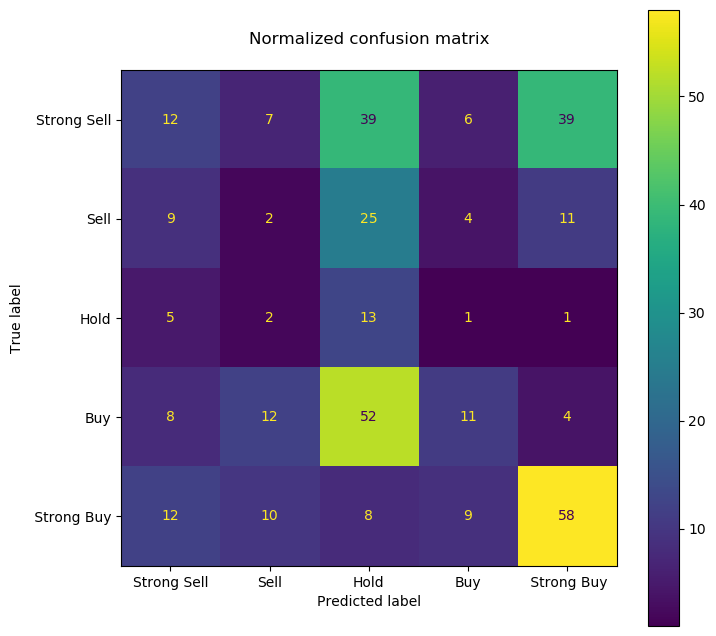

In [134]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(tuned_model, X_test, y_test, display_labels=['Strong Sell', 'Sell', 'Hold', 'Buy', ' Strong Buy'], ax=ax)
plt.title('Normalized confusion matrix\n')
plt.show()

In [135]:
df_to_predict = df_labelled[features].tail(50)

results = df_labelled[target].tail(50)
results_map = {
    0 : 'Strong Sell',
    1 : 'Sell',
    2 : 'Hold',
    3 : 'Buy',
    4 : 'Strong Buy'
}

y_pred_proba = tuned_model.predict_proba(df_to_predict)

suggestions = []

probs = [[] for _ in range(5)]
prob_labels = ['Strong Sell', 'Sell', 'Hold', 'Buy', 'Strong Buy']

for SELL, sell, hold, buy, BUY in y_pred_proba:
    probs[0].append(SELL)
    probs[1].append(sell)
    probs[2].append(hold)
    probs[3].append(buy)
    probs[4].append(BUY)
    
    suggestion = 'Unsure'
    if hold > 0.4:
        suggestion = 'Hold'
    elif buy > 0.4:
        suggestion = 'Buy'
    elif sell > 0.4:
        suggestion = 'Sell'
    elif BUY > 0.4:
        suggestion = 'Strong Buy'
    elif SELL > 0.4:
        suggestion = 'Strong Sell'
    suggestions.append(suggestion)

df_to_predict['Actual'] = results
df_to_predict['Actual'] = df_to_predict['Actual'].map(lambda x : results_map[x])

for col, col_label in zip(probs, prob_labels):
    df_to_predict[col_label] = col
    
df_to_predict['Advisor'] = suggestions

df_output = df_to_predict.tail(50)

In [136]:
df_output

,DIX,GEX,DIX Diff.,GEX Diff.,SP500 EWM20 Diff.,Actual,Strong Sell,Sell,Hold,Buy,Strong Buy,Advisor
Date,,,,,,,,,,,,
2020-01-30,0.437035,2.070349e+09,-0.012466,3.232924e+08,10.595051,Strong Sell,0.181057,0.225649,0.085612,0.220117,0.287565,Unsure
2020-01-31,0.424569,1.546001e+09,-0.012466,-5.243479e+08,-43.016858,Strong Buy,0.149853,0.097523,0.137344,0.205849,0.409432,Strong Buy
2020-02-03,0.408136,1.886169e+09,-0.016433,3.401678e+08,-17.748586,Strong Buy,0.215274,0.209798,0.114941,0.234028,0.225959,Unsure
2020-02-04,0.389276,3.359119e+09,-0.018860,1.472950e+09,27.976517,Strong Sell,0.166105,0.202170,0.274889,0.287783,0.069054,Unsure
2020-02-05,0.410363,4.067938e+09,0.021087,7.088193e+08,58.878754,Strong Sell,0.149044,0.123493,0.490886,0.188274,0.048304,Hold
2020-02-06,0.418595,5.336331e+09,0.008232,1.268392e+09,63.305063,Strong Sell,0.429003,0.133941,0.337524,0.055603,0.043929,Strong Sell
2020-02-07,0.430928,4.120952e+09,0.012333,-1.215379e+09,40.917914,Strong Sell,0.117222,0.168231,0.494802,0.171169,0.048576,Hold
2020-02-10,0.409942,5.361524e+09,-0.020986,1.240572e+09,59.097160,Strong Sell,0.121379,0.301715,0.443963,0.072919,0.060024,Hold
2020-02-11,0.424073,5.722247e+09,0.014132,3.607229e+08,58.580764,Strong Sell,0.104040,0.163976,0.617255,0.064092,0.050636,Hold


In [137]:
#next time

#filter data on high vix

#look for gamma flips